# Preamble

Summary of concerns and assumptions:
1) Assume SC meals (self-catered) have not had their price written in error, despite somehow costing more than full-board
2) Assume 'adr' (avg daily rate) is to be multiplied by nights stayed to find overall room rental revenue per booking, exclusive of meal costs
- See source: "Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights"
3) Assume meals are applied to every non-baby guest in the same booking, for every day (nights + 1) spent
4) Assume Null children --> 0 children
5) Assume bookings of zero pax are unsuable data
6) Assume bookings with zero adr (avg daily rate) yet which are not cancelled are unusable data

# Prelim

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Remove scientific notation in larger figures
pd.options.display.float_format = '{:.2f}'.format

## Load Data

In [3]:
# 2018 to 2020
# sheet_name = None --> all worksheets
df1 = pd.read_excel(r"D:\Code\Data Analysis\01 Hotel Bookings\hotel_revenue_historical_full-2.xlsx", sheet_name = None)

In [4]:
# 2015 to 2017
df2 = pd.read_csv(r"D:\Code\Data Analysis\01 Hotel Bookings\hotels.csv")

In [5]:
# Concat sheets within df1, having verified in source that columns match. Also from df2.
# ---> Consolidated fact table of bookings data 2015 to 2020
df_main = pd.concat([df1['2018'], df1['2019'], df1['2020'], df2])
pd.set_option("display.max.columns", 50)

In [6]:
df_main[df_main["is_canceled"] == 0].head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
7951,Resort Hotel,0,342,2018,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2018-07-01 00:00:00
7952,Resort Hotel,0,737,2018,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2018-07-01 00:00:00
7953,Resort Hotel,0,7,2018,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2018-07-02 00:00:00
7954,Resort Hotel,0,13,2018,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,NaN,0,Transient,75.00,0,0,Check-Out,2018-07-02 00:00:00
7955,Resort Hotel,0,14,2018,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,NaN,0,Transient,98.00,0,1,Check-Out,2018-07-03 00:00:00
7956,Resort Hotel,0,14,2018,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,NaN,0,Transient,98.00,0,1,Check-Out,2018-07-03 00:00:00
7957,Resort Hotel,0,0,2018,July,27,1,0,2,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.00,0,0,Check-Out,2018-07-03 00:00:00
7958,Resort Hotel,0,9,2018,July,27,1,0,2,2,0.00,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.00,NaN,0,Transient,103.00,0,1,Check-Out,2018-07-03 00:00:00
7959,Resort Hotel,0,35,2018,July,27,1,0,4,2,0.00,0,HB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240.00,NaN,0,Transient,145.00,0,0,Check-Out,2018-07-05 00:00:00
7960,Resort Hotel,0,68,2018,July,27,1,0,4,2,0.00,0,BB,USA,Online TA,TA/TO,0,0,0,D,E,0,No Deposit,240.00,NaN,0,Transient,97.00,0,3,Check-Out,2018-07-05 00:00:00


In [7]:
# Dimension table 1
# Typically would assume SC (self-catered) --> cheaper
# Seems not the case this time. Raise concern of error, but go along with it (do not drop SC or any such action)

df_meal_cost = df1['meal_cost']
df_meal_cost

,Cost,meal
0,0.00,Undefined
1,12.99,BB
2,17.99,HB
3,21.99,FB
4,35.00,SC


In [8]:
# Dimension table 2
# Note discounted price would be price * (1 - discount)

df_market_segment = df1['market_segment']
df_market_segment

,Discount,market_segment
0,0.00,Undefined
1,0.10,Direct
2,0.10,Groups
3,0.15,Corporate
4,0.20,Aviation
5,0.30,Offline TA/TO
6,0.30,Online TA
7,1.00,Complementary


# Clean and Structure Data

## Dupes, Nulls, Anomalies

In [9]:
# Any dupes?
# 73185
len(df_main[df_main.duplicated()])

73185

In [10]:
# Can't find justification for why these dupes need to be kept, so drop them
df_main.drop_duplicates(inplace=True)
len(df_main[df_main.duplicated()])

0

In [11]:
df_main.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                              12
babies                                 0
meal                                   0
country                             1013
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              26732
company         

Note: null categorical data like 'agent' and 'company' explained in data dictionary as meaning N/A, not missing in value

In [12]:
# Assumption: null children = 0. Need non-null to convert to int (from float), in next cell
df_main["children"] = df_main["children"].fillna(value = 0)

In [13]:
# Convert datatypes:
    # children to integer from float
    # reservation_status_date to datetime from object
df_main["children"] = df_main["children"].astype(np.int64)
df_main["reservation_status_date"] = pd.to_datetime(df_main["reservation_status_date"])#.dt.date
df_main.dtypes

hotel                                     object
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

## Feature Engineering, Further Cleaning

In [14]:
# Convert month from English name ('July') to number (7)
df_main["arrival_date_month"] = pd.to_datetime(df_main["arrival_date_month"], format = "%B").dt.month

# Combine separate arrival date columns into singular date column
df_main["arrival_date"] = pd.to_datetime({
    'year': df_main['arrival_date_year'],
    'month': df_main['arrival_date_month'],
    'day': df_main['arrival_date_day_of_month']
})

In [15]:
df_main[["arrival_date", "arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"]].head(15)

,arrival_date,arrival_date_year,arrival_date_month,arrival_date_day_of_month
0,2018-07-01,2018,7,1
1,2018-07-01,2018,7,1
2,2018-07-01,2018,7,1
3,2018-07-01,2018,7,1
4,2018-07-01,2018,7,1
5,2018-07-02,2018,7,2
6,2018-07-02,2018,7,2
7,2018-07-02,2018,7,2
8,2018-07-02,2018,7,2
9,2018-07-02,2018,7,2


In [16]:
# Don't drop - easier filtering if retained
#df_main = df_main.drop(labels = ["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"], axis = 1)

In [17]:
df_main["pax"] = df_main["adults"] + df_main["children"] + df_main["babies"]

In [18]:
len(df_main[df_main["pax"] == 0])

361

In [19]:
# Absent deeper knowledge on booking system, assume 0 pax bookings are in error / not usable
df_main = df_main[df_main["pax"] != 0].copy()

In [20]:
# adr := sum of all lodging transactions divided by total number of staying nights
# So sum of all lodging transactions per booking (row) is adr * nights

df_main["nights"] = df_main["stays_in_week_nights"] + df_main["stays_in_weekend_nights"]
df_main[["nights", "stays_in_week_nights", "stays_in_weekend_nights"]].head(10)

,nights,stays_in_week_nights,stays_in_weekend_nights
0,3,3,0
1,3,3,0
2,4,4,0
3,7,5,2
4,10,8,2
5,4,3,1
6,4,3,1
7,4,3,1
8,5,3,2
9,7,5,2


In [21]:
# 3,634 entries are not cancelled yet have adr (avg daily rate) of 0.
# adr is "calculated by dividing the sum of all lodging transactions by the total number of staying nights"
df_main.groupby([(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)]).size()

False    184422
True       3369
dtype: int64

In [22]:
# There are examples below of adr = 0, canceled = 0, and nights != 0
# Even if strictly nights = 0 under these conditions, that wouldn't easily explain anything, but might have been a hint into reasoning

# df_main[["nights", "stays_in_weekend_nights", "stays_in_week_nights"]][(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)].sort_values(by = df_main["nights"], ascending=False)

df_main[(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)][["nights", "stays_in_weekend_nights", "stays_in_week_nights"]].sort_values(by="nights", ascending=False)

,nights,stays_in_weekend_nights,stays_in_week_nights
34715,48,14,34
54704,48,14,34
1655,46,13,33
8989,46,13,33
65696,46,13,33
...,...,...,...
115483,0,0,0
117701,0,0,0
118029,0,0,0
18836,0,0,0


In [23]:
# Examples below show that cases of adr = 0 & is_canceled = 0 do not congregate around one particular dimension value,
# which would hint that the result is systematic --> stronger evidence that this is erroneous / not by design
df_main[(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)].groupby("market_segment").size().sort_values(ascending = False)
# df_main[(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)].groupby("distribution_channel").size().sort_values(ascending = False)
# df_main[(df_main["adr"] == 0) & (df_main["is_canceled"] == 0)].groupby("customer_type").size().sort_values(ascending = False)

market_segment
Complementary    1228
Online TA         661
Offline TA/TO     487
Groups            451
Direct            404
Corporate         132
Aviation            6
dtype: int64

In [24]:
# Note too that "Complementary" market segment discount of 100% is applied in post, as seen by max 'adr' for this segment being > 0
df_main.groupby(df_main["market_segment"] == "Complementary")["adr"].max()

market_segment
False   5400.00
True     170.00
Name: adr, dtype: float64

In [25]:

# Absent more detailed knowledge of subject matter, assume the examples found are unusable
# Even if these are explained by e.g. vouchers and perks, there is no alternate column to demonstrate this anyway
df_main = df_main[~((df_main["adr"] == 0) & (df_main["is_canceled"] == 0))].copy()
# After slicing, e.g. as above, Pandas does not necessarily create a totally new df_main, rather just a shallow copy, or even just a view
# So later when e.g. adding new columns, Pandas not sure if applying to original or view, and changes may or may not exist
# Therefore make a deep copy

In [26]:
# reservation_status := ['canceled', 'check out', 'no show']
# reservation_status_date := "Date at which the last status was set [...] understand when was the booking canceled or when did the customer checked-out of the hotel"
df_main.groupby("arrival_date_year")["reservation_status_date"].agg(['min', 'max'])
# (Later standardise the format of column)

,min,max
arrival_date_year,,
2015,2014-10-17,2016-01-14
2016,2015-06-26,2017-01-14
2017,2015-10-21,2017-09-14
2018,2014-10-17,2019-01-14
2019,2014-10-17,2020-01-14
2020,2018-10-21,2020-09-14


In [27]:
# Some min dates look suspicious
# Technically, would be possible in the case of cancellations for the reserve_status_date to preceded arrival_date

# First see if any cases where reservation_status_date < arrival_date but corresponding status was not cancellation
# Where 'is_canceled' = 1 yet reservation_status is not 'Canceled', we prioritise the reservation_status, in alignment with documentation

# df_main[(df_main["reservation_status_date"] < df_main["arrival_date"]) & (df_main["reservation_status"] != 'Canceled')]
df_main[["is_canceled", "reservation_status", "reservation_status_date", "arrival_date"]][(df_main["reservation_status_date"] < df_main["arrival_date"]) & (df_main["reservation_status"] != 'Canceled')]

,is_canceled,reservation_status,reservation_status_date,arrival_date
56104,1,No-Show,2019-03-28,2019-07-17
66832,0,Check-Out,2019-01-05,2019-12-08
66852,0,Check-Out,2019-01-05,2019-12-17
66889,0,Check-Out,2019-01-02,2019-12-23
66905,0,Check-Out,2019-01-01,2019-12-24
...,...,...,...,...
79259,1,Check-Out,2019-01-06,2019-03-01
79260,1,Check-Out,2018-11-20,2019-03-02
79261,1,Check-Out,2018-11-20,2019-03-02
79263,1,Check-Out,2019-01-27,2019-03-02


In [28]:
# 328 rows cannot be explained - delete
df_main = df_main[~((df_main["reservation_status_date"] < df_main["arrival_date"]) & (df_main["reservation_status"] != 'Canceled'))].copy()

In [29]:
# lead_time := number of days [...] between the entering date of the booking into the PMS and the arrival date
# PMS := Property Management System

# Wouldn't make sense for reservation_status_date to precede the booking_date in any scenario (cancellation, no show, check out)
# Derive booking_date from datediff(arrival - lead time) then compare:

df_main["booking_date"] = df_main["arrival_date"] - pd.to_timedelta(df_main["lead_time"], unit='days')
df_main[["is_canceled", "reservation_status", "reservation_status_date", "arrival_date", "lead_time", "booking_date"]][df_main["booking_date"] > df_main["reservation_status_date"]]

,is_canceled,reservation_status,reservation_status_date,arrival_date,lead_time,booking_date
566,1,Canceled,2014-11-18,2018-09-03,297,2017-11-10
4215,1,Canceled,2014-10-17,2018-07-09,265,2017-10-17
4216,1,Canceled,2014-10-17,2018-07-02,258,2017-10-17
4236,1,Canceled,2014-10-17,2018-07-09,265,2017-10-17
4255,1,Canceled,2014-10-17,2018-07-16,272,2017-10-17
...,...,...,...,...,...,...
15287,1,Canceled,2020-01-09,2020-08-25,228,2020-01-10
15325,1,Canceled,2020-02-12,2020-08-26,195,2020-02-13
15346,1,Canceled,2020-02-19,2020-08-27,189,2020-02-20
15413,1,Canceled,2020-02-04,2020-08-30,207,2020-02-05


In [30]:
# Can't explain above 688 rows where booking_date > reservation_status_date ("latest" status), so delete:

df_main = df_main[~(df_main["booking_date"] > df_main["reservation_status_date"])].copy()

In [31]:
# reservation_status == 'Canceled' := customer cancelled
# is_canceled == 1 := cancelled on booking system ... presumably by hotel operator
# So below instances of reservation_status == 'Check-Out' but is_canceled == 1 don't make sense?

df_main[(df_main["is_canceled"] == 1)].groupby("reservation_status").size()

reservation_status
Canceled     47852
Check-Out        2
No-Show       2179
dtype: int64

In [32]:
# Drop 2 instances of is_canceled == 1 and reservation_status == 'Check-Out'
# Might be an explanation, but assume there isn't
df_main = df_main[~((df_main["is_canceled"] == 1) & (df_main["reservation_status"] == 'Check-Out'))].copy()

In [33]:
df_main[(df_main["is_canceled"] == 0)].groupby("reservation_status").size()

reservation_status
Check-Out    133373
dtype: int64

### Lead-time Group Set-up

Lead-time is very high-ranging, and different cohorts within are generally known in hospitality to behave differently.<br>
Therefore, best to break it up into categories

In [34]:
# # bins = [-1, 7, 30, 90, 180, df_main['lead_time'].max()]
# labels = ['Last Minute', 'Short', 'Medium', 'Long', 'Very Long']
# df_main['lead_time_group'] = pd.cut(df_main['lead_time'], bins=bins, labels=labels)

In [35]:
bins = [-1, 3, 14, 45, 120, df_main['lead_time'].max()]
labels = ['Last Minute', 'Short', 'Medium', 'Long', 'Very Long']
df_main['lead_time_group'] = pd.cut(df_main['lead_time'], bins=bins, labels=labels)

Justification: these are, from online research, bands which represent typical customer cohorts which ought to have similar behaviours and therefore strategies that are effective upon them

In [36]:
df_main.groupby("lead_time_group").size()

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\1851971650.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_main.groupby("lead_time_group").size()


lead_time_group
Last Minute    26501
Short          24785
Medium         37775
Long           47647
Very Long      46696
dtype: int64

### Seasonal Analysis Set-up

In [37]:
df_main.groupby("arrival_date_year")["arrival_date"].agg(['min', 'max']).reset_index()

,arrival_date_year,min,max
0,2015,2015-07-01,2015-12-31
1,2016,2016-01-01,2016-12-31
2,2017,2017-01-01,2017-08-31
3,2018,2018-07-01,2018-12-31
4,2019,2019-01-01,2019-12-31
5,2020,2020-01-01,2020-08-31


https://www.practiceportuguese.com/learning-notes/seasons-of-the-year/
- Spring: 20 Mar < 21 June
- Summer: 21 June < 23 Sept
- Autumn: 23 Sept < 21 Dec
- Winter: 21 Dec < 20 Mar

In [38]:
# Though we can extract mm-dd from yyyy-mm-dd as below,
# this outputs as object dtype, which can't easily be compared to date parameters.
# df_main["arrival_date"].dt.strftime('%m-%d')
# So instead, use day of year:

df_main['day_of_year'] = df_main["arrival_date"].dt.dayofyear

def get_season(day_of_year):
    if 80 <= day_of_year <= 171:  # Mar 20 - Jun 20
        return 'spring'
    elif 172 <= day_of_year <= 266:  # Jun 21 - Sep 22
        return 'summer'
    elif 267 <= day_of_year <= 355:  # Sep 23 - Dec 20
        return 'autumn'
    else:
        return 'winter'

df_main['season'] = df_main['day_of_year'].apply(get_season)
# dataframe.apply(function) := apply a function along an axis of a dataframe

2015, 2018: partial summer, full autumn, partial winter <br>
2016, 2019: all seasons <br>
2017, 2020: partial winter, full spring, partial summer <br>

If we are to investigate cancellation *rate* and adr (*"rate"*), it is fine to include the partial seasons. <br>
I.e. we are not aggregating a sum, which would in that case be distorted by different coverage

In [39]:
# Cutom ordering for seasons
season_order = ["spring", "summer", "autumn", "winter"]
df_main['season'] = pd.Categorical(df_main['season'], categories=season_order, ordered=True)

### Revenue Analysis Set-up

In [40]:
# adr is := "C"alculated by dividing the sum of all lodging transactions by the total number of staying nights"
# Interpret this to mean that meals would be a separate cost
# As cancellations = no meal cost (unless up-front?), then ignore for now - add later to analysis if seems relevant
df_main["booking_revenue"] = df_main["adr"] * df_main["nights"]

# Univariate Analysis

Look at the shape of columns to see if any notable data issues or points to note, etc.

In [41]:
df_main.groupby(df_main["arrival_date_year"]).size()

arrival_date_year
2015    12863
2016    41599
2017    31293
2018    12851
2019    54169
2020    30629
dtype: int64

In [42]:
# Sizes conditional on not cancelled
df_main[df_main["is_canceled"] == 0].groupby(["arrival_date_year"]).size()

arrival_date_year
2015    10160
2016    30400
2017    21187
2018    10160
2019    40279
2020    21187
dtype: int64

In [43]:
# To be sure, see min and max dates per year
df_main.groupby("arrival_date_year")["arrival_date"].agg(['min', 'max']).reset_index()

,arrival_date_year,min,max
0,2015,2015-07-01,2015-12-31
1,2016,2016-01-01,2016-12-31
2,2017,2017-01-01,2017-08-31
3,2018,2018-07-01,2018-12-31
4,2019,2019-01-01,2019-12-31
5,2020,2020-01-01,2020-08-31


In [44]:
# Would make sense to normalise to a per-month basis if comparing YoY (and in fact, YTD i.e. equivalent months)
df_months_per_year = df_main.groupby("arrival_date_year", as_index = False)["arrival_date_month"].nunique().rename(columns = {"arrival_date_month" : "count_months_covered"})
df_months_per_year

,arrival_date_year,count_months_covered
0,2015,6
1,2016,12
2,2017,8
3,2018,6
4,2019,12
5,2020,8


In [45]:
# Bookings per month by year:
df_size_by_year = df_main.groupby(df_main["arrival_date_year"], as_index = False).size()
df_size_by_year = df_size_by_year.merge(df_months_per_year, on = "arrival_date_year")
df_size_by_year["size_norm"] = df_size_by_year["size"] / df_size_by_year["count_months_covered"]
df_size_by_year

,arrival_date_year,size,count_months_covered,size_norm
0,2015,12863,6,2143.83
1,2016,41599,12,3466.58
2,2017,31293,8,3911.62
3,2018,12851,6,2141.83
4,2019,54169,12,4514.08
5,2020,30629,8,3828.62


In [46]:
# # Seems 2015 vs 2018; 2017 vs 2020 are just copies?
# df_main.groupby("arrival_date_year")["pax"].sum()
# df_main.groupby("arrival_date_year")["nights"].sum()

In [47]:
# # Below indicates the data across years are not copies
# cols_to_compare = [col for col in df_main.columns if col not in ["arrival_date_year", "arrival_date", "reservation_status", "arrival_date_month", "arrival_date_day_of_month", "arrival_date_week_number"]]

# df_2015 = df_main[df_main["arrival_date_year"] == 2015].sort_values(cols_to_compare).reset_index(drop=True)
# df_2018 = df_main[df_main["arrival_date_year"] == 2018].sort_values(cols_to_compare).reset_index(drop=True)

# print((df_2015[cols_to_compare]).equals(df_2018[cols_to_compare]))
# # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.equals.html

In [48]:
# Size split by hotel type
df_main.groupby(df_main["hotel"]).size()

hotel
City Hotel      110451
Resort Hotel     72953
dtype: int64

In [49]:
# Size split by cancellation
df_main.groupby(df_main["is_canceled"]).size()

is_canceled
0    133373
1     50031
dtype: int64

In [50]:
# Size split by deposit_type
df_main.groupby(df_main["deposit_type"]).size()

deposit_type
No Deposit    180948
Non Refund      2241
Refundable       215
dtype: int64

In [51]:
# Distribution by nights
df_main.aggregate({"nights" : ['min', 'max', 'mean', 'median', 'std']})

,nights
min,0.00
max,69.00
mean,3.68
median,3.00
std,2.74


In [52]:
Q1_nights = df_main['nights'].quantile(0.25)
Q3_nights = df_main['nights'].quantile(0.75)

IQR_nights = Q3_nights - Q1_nights

print(f"Q1: {Q1_nights}, Q3: {Q3_nights}, IQR: {IQR_nights}")

Q1: 2.0, Q3: 5.0, IQR: 3.0


In [53]:
# Whilst 69 nights is many std dev away from mean, it does seem plausible, just from an intuitive sense of hotel booking possibilities
# Other values at the tail support idea that this is not completely out of the blue:
df_main[df_main["nights"] > 21].groupby("nights").size()

nights
22    29
23    12
24    12
25    28
26    12
27     9
28    72
29    25
30    24
33     5
34     2
35    10
38     2
42     8
45     2
56     4
60     3
69     2
dtype: int64

Consider categorising nights stayed into custom short/medium/long stays

In [54]:
# Nights := number of nights guest did stay or booked to stay
# Note too that any instances of nights == 0 necessarily has is_canceled = 1
# Which may or may not be of business importance - best to check.
# Realistically, room probably can be booked for zero nights, so leave as is
# len(df_main.loc[(df_main["nights"] == 0) & (df_main["is_canceled"] == 0)])

len(df_main[((df_main["nights"] == 0) & (df_main["is_canceled"] == 0))])

0

In [55]:
# Distribution by pax
df_main.aggregate({"pax" : ['min', 'max', 'mean', 'median', 'std']})

,pax
min,1.00
max,55.00
mean,2.03
median,2.00
std,0.82


In [56]:
Q1_pax = df_main['pax'].quantile(0.25)
Q3_pax = df_main['pax'].quantile(0.75)

IQR_pax = Q3_pax - Q1_pax

print(f"Q1: {Q1_pax}, Q3: {Q3_pax}, IQR: {IQR_pax}")

Q1: 2.0, Q3: 2.0, IQR: 0.0


In [57]:
# 55 pax is mny std dev away from mean, but as with 'nights', is probably a situation where statistical norms take second place to business sense,
# and it does seem reasonable for a booking of 55 pax to emerge, especially from a 'Group' or 'Corporate' category.
# Would intend to check on this for a real stakeholder. For this project, leave as is
# Other values at the tail support idea that this is not completely out of the blue:
df_main.groupby("pax").size()

pax
1      33397
2     120813
3      20822
4       8040
5        282
6          3
10         6
12         5
20         6
26        15
27         6
40         3
50         3
55         3
dtype: int64

As with # nights, consider categorising pax in groups

In [58]:
# Other sizing and distributions
# df_main.groupby("distribution_channel")["pax"].agg(['mean', 'median', 'min', 'max'])
# df_main.groupby("customer_type")["pax"].agg(['mean', 'median', 'min', 'max'])
# df_main.groupby("market_segment")["pax"].agg(['mean', 'median', 'min', 'max'])
# df_main.groupby(["reserved_room_type"]).size()
# df_main.groupby(["assigned_room_type"]).size()

In [59]:
# Distribution by lead time
df_main.aggregate({"lead_time" : ['min', 'max', 'mean', 'median', 'std']})

,lead_time
min,0.00
max,709.00
mean,78.92
median,48.00
std,85.20


In [60]:
Q1_lead_time = df_main['lead_time'].quantile(0.25)
Q3_lead_time = df_main['lead_time'].quantile(0.75)

IQR_lead_time = Q3_lead_time - Q1_lead_time

print(f"Q1: {Q1_lead_time}, Q3: {Q3_lead_time}, IQR: {IQR_lead_time}")

Q1: 11.0, Q3: 123.0, IQR: 112.0


In [61]:
# Booking 709d in advance is quite far out, but still believable, and below suggests it is part of a legitimate long tail
df_main[df_main["lead_time"] >= 123].groupby(["lead_time"]).size()

lead_time
123    440
124    455
125    422
126    395
127    402
      ... 
615      4
622      4
626      2
629      4
709      2
Length: 355, dtype: int64

In [62]:
df_main.groupby("lead_time_group").size()

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\1851971650.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_main.groupby("lead_time_group").size()


lead_time_group
Last Minute    26501
Short          24785
Medium         37775
Long           47647
Very Long      46696
dtype: int64

TA = Travel Agents
TO = Tour Operators

In [63]:
df_main.groupby("market_segment").size()

market_segment
Aviation            446
Complementary       306
Corporate          9104
Direct            25207
Groups            10625
Offline TA/TO     30159
Online TA        107551
Undefined             6
dtype: int64

In [64]:
df_main.groupby(["distribution_channel"]).size()

distribution_channel
Corporate     10749
Direct        26766
GDS             355
TA/TO        145519
Undefined        15
dtype: int64

Agent := ID of travel angency making booking

In [65]:
# Note below examples of agent not null but other relevant columns not strictly being 'TA', which is what we would expect, given the terminology at hand
# ... not strictly intuitive what the business definitions here are - worth clarifying with SME. For now just leave as is (don't drop, etc.)
agent_not_null = df_main[df_main['agent'].notna()]
agent_not_null = agent_not_null[['distribution_channel', 'market_segment']].drop_duplicates().copy()
agent_not_null

,distribution_channel,market_segment
0,TA/TO,Online TA
1,TA/TO,Offline TA/TO
18,Direct,Direct
67,TA/TO,Direct
82,Direct,Groups
360,Corporate,Corporate
562,TA/TO,Groups
954,Corporate,Groups
2354,Undefined,Direct
2445,Undefined,Online TA


In [66]:
# There are 333 distinct agents
len(df_main["agent"].unique())

333

'Company' := ID of the company/entity that made the booking or responsible for paying the booking

In [67]:
# There are 346 distinct companies
len(df_main["company"].unique())

346

**Univariate Analysis Takeaways**

- There is expansive data / large ranges in interesting possible variables like pax, lead-time, market-segment, distribution channel, nights, cancellations
- Such that for numerical ones like nights and pax, may be adviseable to create categories for classifying batches
- As is probably expected, nights and pax have a tendency towards lower numbers (smaller bookings for fewer nights), but this does not mean an absence of larger, longer bookings

# Cancellations Analysis

- 'is_canceled' refers to hotel booking system
- 'reservation_status' refers to customer decision (canceled or no-show or checked-out already)
- Here, we will look into reservation_status == 'Canceled' --> has the customer announced a conscious decision to cancel?


https://experience-crm.fr/en/where-do-cancellations-come-from/#:~:text=Average%20cancellation%20rates&text=The%20average%20percentage%20of%20canceled,no%20room%20for%20nasty%20surprises.
- Published 2016-11-14; modified 2023-08-02
- The average percentage of canceled reservations, across **all sources**, is currently **24%**.
-  If you look only at **online** bookings, this rate increases to **38%**,
- and therefore all **“offline”** reservations [...] 10%.

https://hospitalitytech.com/global-cancellation-rate-hotel-reservations-reaches-40-average
- Published 2019-04-24; modified 01/14/2025
- **online** distribution performance of more than 200 different channels for 680 properties in Europe between 2014 and 2018
- With the exception of 2018, every single channel has observed a marked increase in cancellation rate YoY.
- And, even in 2018, the number was 7.1 points above 2014.
- With a global average of almost **40%** cancellation rate [...].
- 2014 to 2018: 32.5%, 34.8%, 39.6%, 41.3%, 39.6%
- Across **online** sources: Booking Group, Expedia Group, Hotelbeds Group, HRS Group, Other OTAs, Other Wholesalers, Website Direct

https://www.phocuswire.com/One-in-five-hotel-bookings-on-the-web-are-cancelled
- Published 31 Dec, 2015
- Some **19%** of hotels that are booked **online** are cancelled before the guest arrives at the hotel, according to data provided by 

https://www.d-edge.com/avoid-guests-ghosting/
- According to our 2024 Hotel Distribution Report, hotel booking cancellation rates range from 18% to 42%.
- In Europe, the cancellation rate for direct bookings was 18% in 2023 [...] these rates increased for **OTA** bookings: in Europe, Expedia had a cancellation rate of 31%, while Booking Holdings reached 42%. 


In [68]:

len_canc = len(df_main[df_main["reservation_status"] == 'Canceled'])
len_total = len(df_main)
pc_canc = round((len_canc / len_total), 3) * 100

print(f"bookings cancelled: {len_canc},\nbookings total: {len_total},\npc_cancelled: {pc_canc}")

bookings cancelled: 47852,
bookings total: 183404,
pc_cancelled: 26.1


26.1% of bookings end up being canceled by the customer<br>
With this limited perspective (considering all channels indiscriminately, rudimentary market research), we might say 26.1% is acceptable / comaprable to market standards, but not outstanding.<br>
Although we might better treat the '40%' value as an outlier, and thus deem our cancellation rate over the benchmark, and in need of special attention.
(18% < 24% < 26.1% < ~40%).<br>
In any case, whilst there would be greater thrust to investigate the issue if indeed deemed below standard,<br>
it is always worth gaining insight into cancellation rates, as any amount of optimisation in this regard is worthwhile.

In [69]:
df_main_cancelled = df_main[df_main["is_canceled"] == 1]
df_main_cancelled.groupby("is_canceled").size()

is_canceled
1    50031
dtype: int64

In [70]:
df_main_cancelled.groupby("deposit_type").size()

deposit_type
No Deposit    47857
Non Refund     2125
Refundable       49
dtype: int64

Note that the non-refundable population of cancelled bookings is so small as to pretty much be negligible.<br>
Regardless, still do consider this in analysis.

## Time-based Variables vs Cancellations (Cancellation Rate over Time)

What is the shape of cancellation volume / rate over time? Especially, is it rising?

In [71]:
df_yyyy_cancellations = df_main.groupby("arrival_date_year").size().reset_index().rename(columns = {0 : "bookings"})

df_yyyy_cancellations2 = df_main[["arrival_date_year", "is_canceled"]].groupby("arrival_date_year")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_yyyy_cancellations = df_yyyy_cancellations.merge(df_yyyy_cancellations2, on = "arrival_date_year")

df_yyyy_cancellations["cancellation_rate"] = (df_yyyy_cancellations["cancellations"] / df_yyyy_cancellations["bookings"]) * 100
df_yyyy_cancellations = df_yyyy_cancellations[["arrival_date_year", "cancellation_rate", "bookings", "cancellations"]]
df_yyyy_cancellations

,arrival_date_year,cancellation_rate,bookings,cancellations
0,2015,21.01,12863,2703
1,2016,26.92,41599,11199
2,2017,32.29,31293,10106
3,2018,20.94,12851,2691
4,2019,25.64,54169,13890
5,2020,30.83,30629,9442


In [72]:
df_canc_per_y = df_size_by_year[["arrival_date_year", "count_months_covered"]].merge(df_yyyy_cancellations[["arrival_date_year", "cancellation_rate", "cancellations"]], on = "arrival_date_year")
df_canc_per_y["canc_per_m"] = df_canc_per_y["cancellations"] / df_canc_per_y["count_months_covered"]
df_canc_per_y = df_canc_per_y[["arrival_date_year", "cancellation_rate", "canc_per_m"]].copy()
df_canc_per_y['arrival_date_year'] = df_canc_per_y['arrival_date_year'].astype(str) # otherwise plt doesn't read dates properly along X-axis of chart
df_canc_per_y

,arrival_date_year,cancellation_rate,canc_per_m
0,2015,21.01,450.50
1,2016,26.92,933.25
2,2017,32.29,1263.25
3,2018,20.94,448.50
4,2019,25.64,1157.50
5,2020,30.83,1180.25


In [146]:
# df_canc_per_y.dtypes

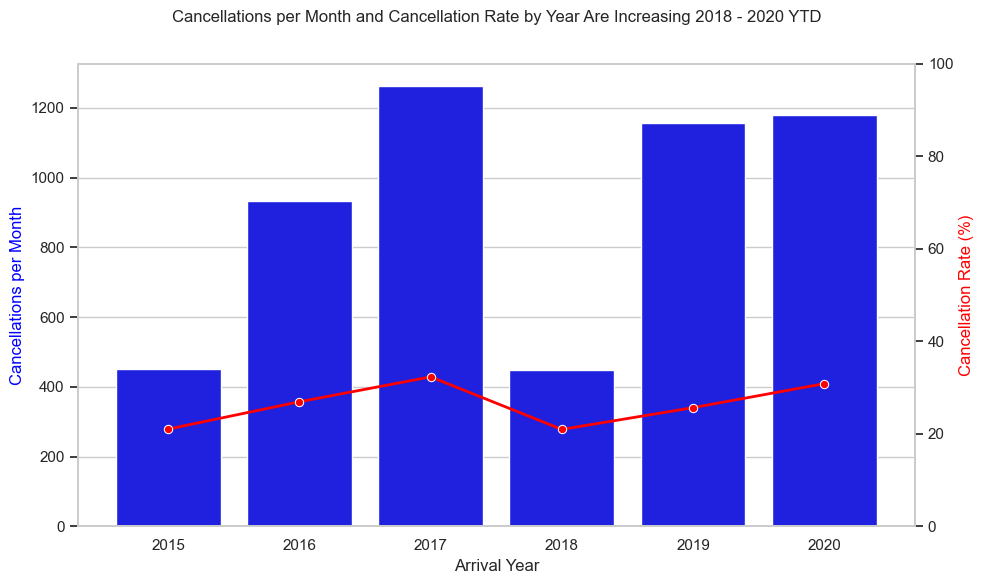

In [74]:
# https://www.geeksforgeeks.org/data-visualization/combining-barplots-and-lineplots-with-different-y-axes-a-technical-guide/

sns.set_theme(style='whitegrid')

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot: cancellations per month
sns.barplot(
    x='arrival_date_year', 
    y='canc_per_m', 
    data=df_canc_per_y, 
    ax=ax1, 
    color='blue', 
    label='Cancellations per Month',
    legend = False
)

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.grid(False)

# Line plot: cancellation rate
sns.lineplot(
    x='arrival_date_year', 
    y='cancellation_rate', 
    data=df_canc_per_y, 
    ax=ax2, 
    color='red', 
    marker='o', 
    linewidth=2, 
    label='Cancellation Rate',
    legend = False
)

# Adjust the scale of the secondary y-axis
ax2.set_ylim(0, 100)

# Axis labels and title
ax1.set_xlabel("Arrival Year")
ax1.set_ylabel("Cancellations per Month", color='blue')
ax2.set_ylabel("Cancellation Rate (%)", color='red')
plt.title("Cancellations per Month and Cancellation Rate by Year Are Increasing 2018 - 2020 YTD", pad = 30)

# Combine legends from both axes
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Format and display
plt.tight_layout()
plt.savefig("01_cancellations_over_time.png", bbox_inches='tight')
plt.show()

Relatively lower cancellation rate in 2015, 2018 / higher in 2017, 2020.<br>
Good to get to the bottom of that, as an 11 p.p. swing from lowest to highest rate is fairly large and probably has revenue management implications<br>
The above is approx 50% relative increase, so fairly substantial.<br><br>

Also, taking 2021 as current year, or even Q4 2020, we would be worries about the rising cancellation rate trend in 'past 3 years'.<br>

In [75]:
# reminder date range 2020:
print(df_main[df_main["arrival_date_year"] == 2020]["arrival_date"].min(), ".............", df_main[df_main["arrival_date_year"] == 2020]["arrival_date"].max())

2020-01-01 00:00:00 ............. 2020-08-31 00:00:00


In [147]:
# Create YTD 2019 for comparison against YTD 2020
df_2019_ytd = df_main[((df_main["arrival_date"] <= pd.to_datetime("2019-08-31")) & (df_main["arrival_date"] >= pd.to_datetime("2019-01-01"))) | (df_main["arrival_date_year"] == 2020)]
print(df_2019_ytd["arrival_date"].min(), ".............", df_2019_ytd[df_2019_ytd["arrival_date_year"] == 2019]["arrival_date"].max(), ".............", df_2019_ytd["arrival_date"].max())

2019-01-01 00:00:00 ............. 2019-08-31 00:00:00 ............. 2020-08-31 00:00:00


In [77]:
df_2019_ytd_canc = df_2019_ytd.groupby("arrival_date_year").size().reset_index().rename(columns = {0 : "bookings"})

df_2019_ytd_canc2 = df_2019_ytd[["arrival_date_year", "is_canceled"]].groupby("arrival_date_year")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_2019_ytd_canc = df_2019_ytd_canc.merge(df_2019_ytd_canc2, on = "arrival_date_year")

df_2019_ytd_canc["cancellation_rate"] = (df_2019_ytd_canc["cancellations"] / df_2019_ytd_canc["bookings"]) * 100
df_2019_ytd_canc = df_2019_ytd_canc[["arrival_date_year", "cancellation_rate", "bookings", "cancellations"]]
df_2019_ytd_canc

,arrival_date_year,cancellation_rate,bookings,cancellations
0,2019,26.11,31327,8181
1,2020,30.83,30629,9442


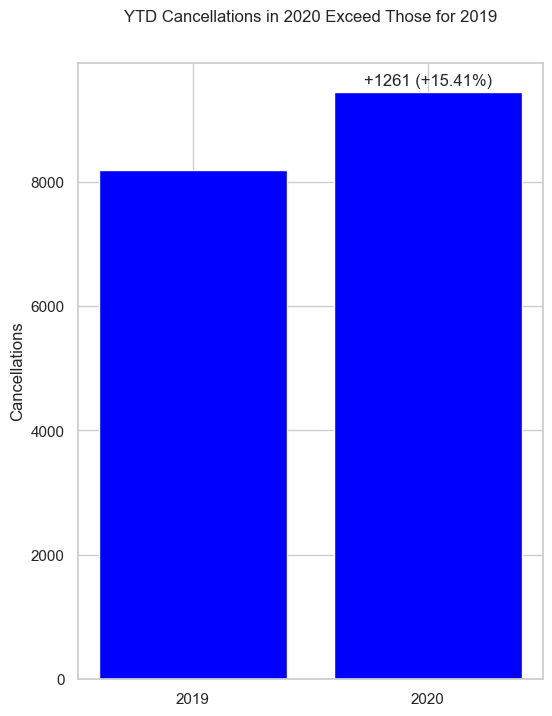

In [78]:
years = df_2019_ytd_canc["arrival_date_year"].astype(str) # otherwise gets treated as continuous number (decimals)
values = df_2019_ytd_canc["cancellations"]

plt.figure(figsize = (6, 8))
plt.bar(years, values, color = "blue")
plt.title('YTD Cancellations in 2020 Exceed Those for 2019', pad = 30)
plt.ylabel('Cancellations')

diff = values.iloc[1] - values.iloc[0] # excess of 2020 over 2019
diff_pc = (diff / values.iloc[0]) * 100
plt.annotate(f'+{diff} (+{diff_pc:.2f}%)',
             xy=(years.iloc[1], values.iloc[1]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
             xytext=(years.iloc[1], values.iloc[1] + 120), # specific positioning of text (x = '2020', y = value for 2020 + padding)
             ha='center') # horizontal alignment of text

plt.savefig("02_YTD_cancellations_2020_vs_2019.png", bbox_inches='tight')
plt.show()

2020 YTD cancellations exceed those of 2019 by 1,261;<br>
cancellation rate higher by 30.83/26.11 = 1.18x,<br>
(30.83/26.11) / 26.11 = 18.1% increase in cancellation rate


! Need to add rate to above chart 

Must remember though, that certain years lack data from certain seasons, so this is not necessarily a year-effect, but a seasonal one.<br>
Reminder:
    2015, 2018: partial summer, full autumn, partial winter; 2016, 2019: all seasons; 2017, 2020: partial winter, full spring, partial summer<br>
Note how these respective year pairs resemble each other in relative within-group cancellation performance, hinting heavily at a seasonal effect.

In [79]:
df_seasonal_cancellations = df_main.groupby("season").size().reset_index().rename(columns = {0 : "bookings"})

df_seasonal_cancellations2 = df_main[["season", "is_canceled"]].groupby("season")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_seasonal_cancellations = df_seasonal_cancellations.merge(df_seasonal_cancellations2, on = "season")

df_seasonal_cancellations["cancellation_rate"] = df_seasonal_cancellations["cancellations"] / df_seasonal_cancellations["bookings"]
df_seasonal_cancellations_basic = df_seasonal_cancellations[["season", "cancellation_rate", "bookings", "cancellations"]]
df_seasonal_cancellations_basic

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\280822747.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal_cancellations = df_main.groupby("season").size().reset_index().rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_15912\280822747.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal_cancellations2 = df_main[["season", "is_canceled"]].groupby("season")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})


,season,cancellation_rate,bookings,cancellations
0,spring,0.29,47128,13740
1,summer,0.30,63464,19168
2,autumn,0.23,37773,8589
3,winter,0.24,35039,8534


The above suggests seasonal explanations for the above year vs year observations:
- Spring higher than Autumn
- Higher rate in Summer

That said, could ultimately still be a year-effect,<br>
e.g. being inherently high in cancellation rate, the fact that 2017 has data for Spring, but the inherently low year 2015 doesn't, means Spring's rate is high. Not due to natural qualities of Spring itself.

In [80]:
df_seasonal_cancellations = df_main.groupby(["arrival_date_year", "season"]).size().reset_index().rename(columns = {0 : "bookings"})

df_seasonal_cancellations2 = df_main[["arrival_date_year", "season", "is_canceled"]].groupby(["arrival_date_year", "season"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_seasonal_cancellations = df_seasonal_cancellations.merge(df_seasonal_cancellations2, on = ["arrival_date_year", "season"])

df_seasonal_cancellations["cancellation_rate"] = df_seasonal_cancellations["cancellations"] / df_seasonal_cancellations["bookings"]
df_seasonal_cancellations = df_seasonal_cancellations[["arrival_date_year", "season", "cancellation_rate", "bookings", "cancellations"]]
df_seasonal_cancellations = df_seasonal_cancellations.sort_values(by = ["arrival_date_year", "season"])
df_seasonal_cancellations_pvt = df_seasonal_cancellations[["arrival_date_year", "season", "cancellation_rate"]]
df_seasonal_cancellations_pvt = df_seasonal_cancellations_pvt.pivot(index = "arrival_date_year", columns = "season", values = "cancellation_rate")
df_seasonal_cancellations_pvt

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\3639752719.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal_cancellations = df_main.groupby(["arrival_date_year", "season"]).size().reset_index().rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_15912\3639752719.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal_cancellations2 = df_main[["arrival_date_year", "season", "is_canceled"]].groupby(["arrival_date_year", "season"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})


season,spring,summer,autumn,winter
arrival_date_year,,,,
2015,NaN,0.25,0.17,0.23
2016,0.26,0.30,0.28,0.22
2017,0.33,0.36,NaN,0.27
2018,NaN,0.25,0.17,0.23
2019,0.26,0.28,0.24,0.23
2020,0.31,0.35,NaN,0.26


Lack of evidence for a seasonal difference in cancellation rate for Spring vs Autumn:<br>
- When considering 2016 and 2019 data (the two 'complete' years), not much difference: 26% (Spring) vs 24% and 28%<br><br>

Indeed, support for idea that lower rate in Autumn overall is a realisation of year-specific factors not inherent to season itself:
- 2015-Autumn and 2018-Autumn are especially low, even compared to other seasons within those years
- I.e. specifically 2015/2018-Autumn were low, not Autumn in general<br><br>

Some evidence of a year-effect whereby cancellation rates are higher in 2017/2020:
- Comparing year vs year for all seasons, these years both always have higher cancellation rates
- Overall then, **comparing year vs year will suffice**, although can always add seasons for even more granularity<br><br>

Some evidence that higher cancellation rates are due to seasonal effect whereby cancellation rates are higher in the Summer:
- This season consistently across years has highest rate of all seasons<br><br>

Summer might have longer lead time because:
- Customers are confident in the weather conditions well in advance
- A higher proportion of trips during this season are leisure trips, as opposed to corporate ones, which are probably booked more suddenly (reactively)?
- Booking pricing design by the hotel management more strongly encourages early reservations for summer?

Ultimately, whilst there might well be some inherent traits of particular years (COVID, visa changes ...) and seasons (weather, holiday schedules...),<br>
that have direct causation on cancellation rates, it is probable that non-time specific factors related to the bookings themselves affect this too, possibly even more intensely than time.<br>
The point to note is that when analysing these other factors, should give consideration to time/seasonal biases.<br>
To be investigated as other factors of cancellations: lead time, market segment

In [81]:
df_seasonal_cancellations_chart = df_seasonal_cancellations[["arrival_date_year", "season", "cancellation_rate"]][df_seasonal_cancellations["arrival_date_year"].isin([2018, 2019, 2020])]
df_seasonal_cancellations_chart = df_seasonal_cancellations_chart.pivot(index = "season", columns = "arrival_date_year", values = "cancellation_rate")
df_seasonal_cancellations_chart *= 100
df_seasonal_cancellations_chart

arrival_date_year,2018,2019,2020
season,,,
spring,NaN,26.33,30.62
summer,24.61,28.15,34.92
autumn,16.85,23.81,NaN
winter,22.51,22.80,26.07


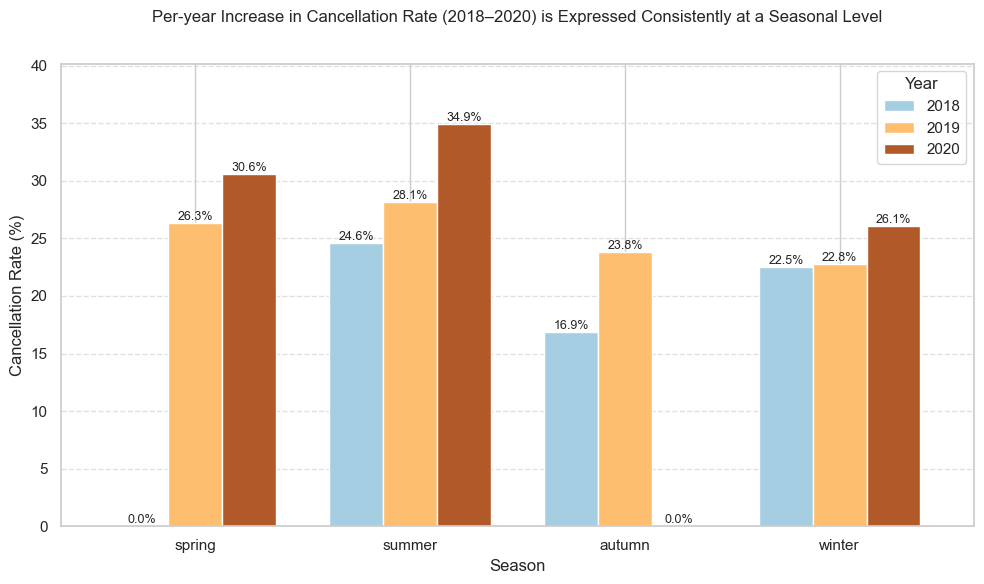

In [82]:
ax = df_seasonal_cancellations_chart.plot(kind='bar', figsize=(10, 6), width=0.75, colormap='Paired')

# Styling
plt.title('Per-year Increase in Cancellation Rate (2018–2020) is Expressed Consistently at a Seasonal Level', pad = 30)
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Season')
plt.xticks(rotation=0)
plt.ylim(0, np.nanmax(df_seasonal_cancellations_chart.values) * 1.15) # max value, ignoring NaN
plt.legend(title='Year')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of bars (optional)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9)

plt.tight_layout()
plt.savefig("03_seasonal_level.png", bbox_inches='tight')
plt.show()

To reiterate the point, the rising cancellation rate for the years 2018 - 2020 are not strictly explainable by different constituent seasons,<br>
as even by-season, there is an increase in cancellation rate for each season, where comparisons (shared seasons) are available.

## Lead Time vs Cancellation Rate

In [83]:
df_main.groupby("is_canceled")["lead_time"].agg(["mean", "median"])

,mean,median
is_canceled,,
0,69.44,38.00
1,104.19,78.00


In [84]:
# sns.boxplot(data=df_main, x='is_canceled', y='lead_time')
# plt.title('Cancelled Bookings Tend to Have Longer Lead Times Than Fulfiled Ones')
# plt.show()

In [85]:
df_lead_grp_cancellations = df_main.groupby("lead_time_group").size().reset_index().rename(columns = {0 : "bookings"})

df_lead_grp_cancellations2 = df_main[["lead_time_group", "is_canceled"]].groupby("lead_time_group")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_lead_grp_cancellations = df_lead_grp_cancellations.merge(df_lead_grp_cancellations2, on = "lead_time_group")

df_lead_grp_cancellations["cancellation_rate"] = df_lead_grp_cancellations["cancellations"] / df_lead_grp_cancellations["bookings"]
df_lead_grp_cancellations_basic = df_lead_grp_cancellations[["lead_time_group", "cancellation_rate", "bookings", "cancellations"]].sort_values(by = "cancellation_rate", ascending = False)
df_lead_grp_cancellations_basic

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\2789998617.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_cancellations = df_main.groupby("lead_time_group").size().reset_index().rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_15912\2789998617.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_cancellations2 = df_main[["lead_time_group", "is_canceled"]].groupby("lead_time_group")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})


,lead_time_group,cancellation_rate,bookings,cancellations
4,Very Long,0.37,46696,17319
3,Long,0.33,47647,15740
2,Medium,0.29,37775,10891
1,Short,0.16,24785,4071
0,Last Minute,0.08,26501,2010


In [86]:
# Get a more generalised view of the numbers:

longer = df_lead_grp_cancellations_basic[df_lead_grp_cancellations_basic['lead_time_group'].isin(['Very Long', 'Long'])]['bookings'].sum()

shorter = df_lead_grp_cancellations_basic[df_lead_grp_cancellations_basic['lead_time_group'].isin(['Short', 'Last Minute'])]['bookings'].sum()

df_lead_grp_cancellations_basic['combined_bookings'] = df_lead_grp_cancellations_basic['lead_time_group'].apply(
    lambda x: longer if x in ['Very Long', 'Long'] 
             else shorter if x in ['Short', 'Last Minute'] 
             else None
)

longer_canc = df_lead_grp_cancellations_basic[df_lead_grp_cancellations_basic['lead_time_group'].isin(['Very Long', 'Long'])]['cancellations'].sum()
shorter_canc = df_lead_grp_cancellations_basic[df_lead_grp_cancellations_basic['lead_time_group'].isin(['Short', 'Last Minute'])]['cancellations'].sum()

df_lead_grp_cancellations_basic['combined_canc'] = df_lead_grp_cancellations_basic['lead_time_group'].apply(
    lambda x: longer_canc if x in ['Very Long', 'Long'] 
             else shorter_canc if x in ['Short', 'Last Minute'] 
             else None
)

df_lead_grp_cancellations_basic['combined_canc_rate'] =  df_lead_grp_cancellations_basic['combined_canc'] / df_lead_grp_cancellations_basic['combined_bookings']

df_lead_grp_cancellations_basic

,lead_time_group,cancellation_rate,bookings,cancellations,combined_bookings,combined_canc,combined_canc_rate
4,Very Long,0.37,46696,17319,94343.00,33059.00,0.35
3,Long,0.33,47647,15740,94343.00,33059.00,0.35
2,Medium,0.29,37775,10891,NaN,NaN,NaN
1,Short,0.16,24785,4071,51286.00,6081.00,0.12
0,Last Minute,0.08,26501,2010,51286.00,6081.00,0.12


As we would expect, longer lead times have higher cancellation rates.<br><br>

Very Long bookings are 29 p.p. or  4.625x more likely than Last Minute ones to cancel.<br>
Treated as a pair, Long and Very Long are 23 p.p. (2.917x) more likely to cancel than Short and Last Minute bookings treated as a pair
<br><br>
This may be because:
- There is literally more opportunity (time) for cancellations to occur.
- The very fact of the reservation being made early could reflect the speculative nature of the booking (mindset of being open to cancel)

In [87]:
# sns.set_theme(style="whitegrid")

# # Create the bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(data=df_lead_grp_cancellations_basic,
#             x='lead_time_group',
#             y='cancellation_rate',
#             color='blue')

# # Percentage labels on top of bars
# for index, row in df_lead_grp_cancellations_basic.iterrows():
#     plt.text(index, row['cancellation_rate'] + 0.01,
#              f"{row['cancellation_rate']*100:.1f}%",
#              ha='center', va='bottom')

# # Set labels and title
# plt.ylabel('Cancellation Rate (%)')
# plt.xlabel('Lead Time Group')
# plt.title('Cancellation Rate by Lead Time Group')
# plt.ylim(0, 1)
# plt.tight_layout()
# plt.show()

In [88]:
df_lead_grp_canc_size = df_main.groupby(["lead_time_group"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})
df_lead_grp_canc_size["total_cancellations"] = sum(df_lead_grp_canc_size["cancellations"])
df_lead_grp_canc_size["cancellations_pc"] = df_lead_grp_canc_size["cancellations"] / df_lead_grp_canc_size["total_cancellations"] 
df_lead_grp_canc_size

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\3423023667.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_canc_size = df_main.groupby(["lead_time_group"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})


,lead_time_group,cancellations,total_cancellations,cancellations_pc
0,Last Minute,2010,50031,0.04
1,Short,4071,50031,0.08
2,Medium,10891,50031,0.22
3,Long,15740,50031,0.31
4,Very Long,17319,50031,0.35


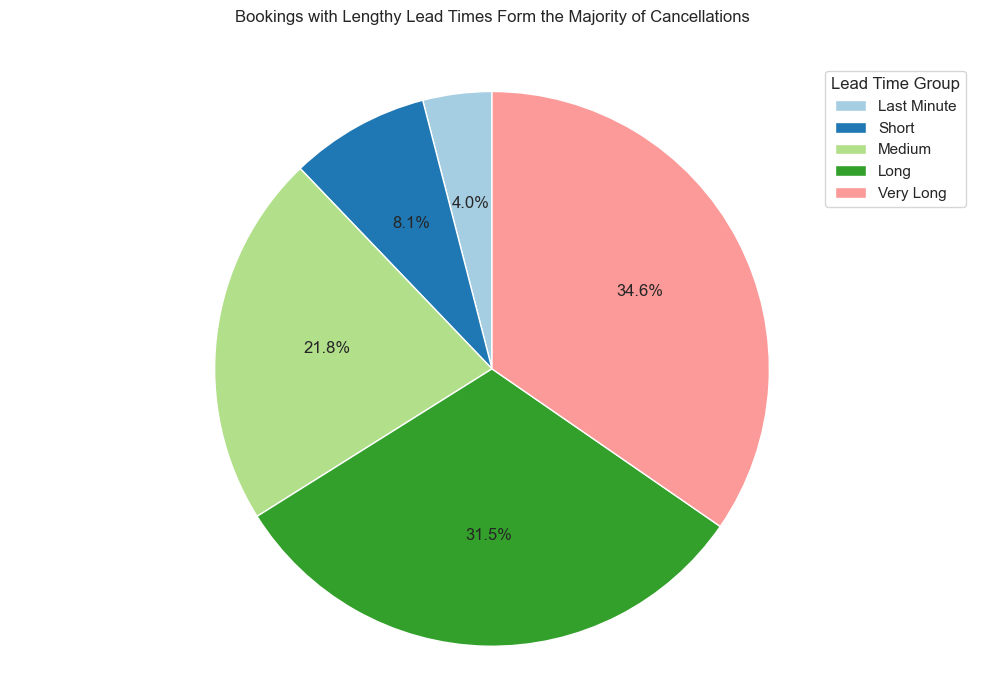

In [160]:
# Data
labels = df_lead_grp_canc_size['lead_time_group']
sizes = df_lead_grp_canc_size['cancellations_pc']

# Plot
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct=lambda pct: f'{pct:.1f}%',
    startangle=90,
    colors=plt.cm.Paired.colors
)

# Legend
plt.legend(wedges, labels, title='Lead Time Group', loc='upper right')

# Make the pie a circle
plt.axis('equal')
plt.title("Bookings with Lengthy Lead Times Form the Majority of Cancellations", pad = 30)
plt.tight_layout()
plt.savefig("04_cancellation_size_by_lead_time.png", bbox_inches='tight')
plt.show()

Long and Very Long represent a large proportion of overall (time-agnostic) cancellations.<br>
Whilst this is partially due to their grand size overall (high volume of bookings --> high volume of cancellations), that is not a disqualifying 'issue':<br>
as they have been deemed to behave similarly on account of having similar lead-time,<br>
these bookings may be treated as such.<br>
I.e. no need to manipulate groupings to be of the same size (no. of bookings) - this would deviate from business logic.<br>

In [90]:
df_lead_grp_szn_size = df_main.groupby(["season", "lead_time_group"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})
df_lead_grp_szn_size["szn_cancellations"] = df_lead_grp_szn_size.groupby("season")["cancellations"].transform("sum")
df_lead_grp_szn_size["cancellations_pc_per_szn"] = df_lead_grp_szn_size["cancellations"] / df_lead_grp_szn_size["szn_cancellations"] 
df_lead_grp_szn_size_pvt = df_lead_grp_szn_size[["season", "lead_time_group", "cancellations_pc_per_szn"]]
df_lead_grp_szn_size_pvt = df_lead_grp_szn_size_pvt.pivot(index = "season", columns = "lead_time_group", values = "cancellations_pc_per_szn")
df_lead_grp_szn_size_pvt

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\3779294688.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_szn_size = df_main.groupby(["season", "lead_time_group"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})
C:\Users\danie\AppData\Local\Temp\ipykernel_15912\3779294688.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_szn_size["szn_cancellations"] = df_lead_grp_szn_size.groupby("season")["cancellations"].transform("sum")


lead_time_group,Last Minute,Short,Medium,Long,Very Long
season,,,,,
spring,0.03,0.07,0.21,0.36,0.33
summer,0.03,0.06,0.15,0.29,0.47
autumn,0.06,0.10,0.27,0.32,0.26
winter,0.06,0.13,0.32,0.30,0.19


Generally across the seasons, Long and Very Long dominate in terms of percentage contributed to cancellations.<br>
That said, Medium is highly relevant in Autumn/Winter, and Very Long trails in influence compared to it.<br>
The seasonal pattern whereby Spring/Summer cancellations rates > those for Autumn/Spring seem driven by behaviour from Long/Very Long, which make up the bulk of cancellations in these periods.

In [91]:
df_lead_grp_y_size = df_main.groupby(["arrival_date_year", "lead_time_group"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})
df_lead_grp_y_size["y_cancellations"] = df_lead_grp_y_size.groupby("arrival_date_year")["cancellations"].transform("sum")
df_lead_grp_y_size["cancellations_pc_per_y"] = df_lead_grp_y_size["cancellations"] / df_lead_grp_y_size["y_cancellations"] 
df_lead_grp_y_size_pvt = df_lead_grp_y_size[["arrival_date_year", "lead_time_group", "cancellations_pc_per_y"]]
df_lead_grp_y_size_pvt = df_lead_grp_y_size_pvt.pivot(index = "arrival_date_year", columns = "lead_time_group", values = "cancellations_pc_per_y")
df_lead_grp_y_size_pvt *= 100
df_lead_grp_y_size_pvt

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\4110565418.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_y_size = df_main.groupby(["arrival_date_year", "lead_time_group"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})


lead_time_group,Last Minute,Short,Medium,Long,Very Long
arrival_date_year,,,,,
2015,7.10,10.65,21.86,34.59,25.79
2016,4.03,8.89,23.22,33.02,30.84
2017,2.63,6.06,19.55,28.39,43.37
2018,7.13,10.70,21.96,34.75,25.46
2019,4.63,9.24,22.97,33.35,29.80
2020,2.82,6.39,20.57,28.28,41.95


In [92]:
df_lead_grp_y_size_chart = df_lead_grp_y_size_pvt.loc[[2018, 2019, 2020], ["Very Long"]].reset_index()
df_lead_grp_y_size_chart

lead_time_group,arrival_date_year,Very Long
0,2018,25.46
1,2019,29.80
2,2020,41.95


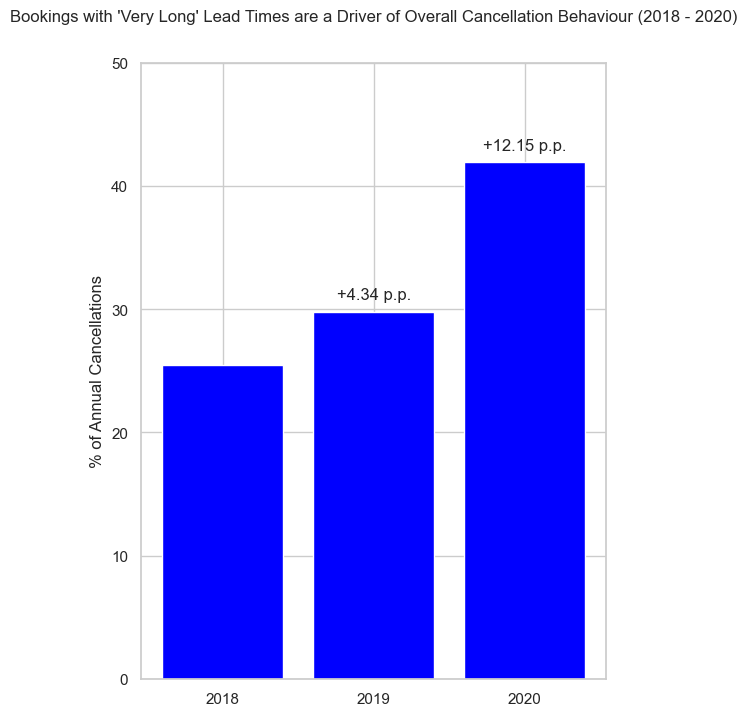

In [161]:
years = df_lead_grp_y_size_chart["arrival_date_year"].astype(str) # otherwise gets treated as continuous number (decimals)
values = df_lead_grp_y_size_chart["Very Long"]

plt.figure(figsize = (6, 8))
plt.bar(years, values, color = "blue")
plt.title("Bookings with 'Very Long' Lead Times are a Driver of Overall Cancellation Behaviour (2018 - 2020)", pad = 30)
plt.ylabel('% of Annual Cancellations')
plt.ylim(0, 50)

for value in range(1, 3): # 1, 2
    diff = values.iloc[value] - values.iloc[value - 1]
    plt.annotate(f'+{diff:.2f} p.p.',
             xy=(years.iloc[value], values.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
             xytext=(years.iloc[value], values.iloc[value] + 1), # specific positioning of text (x = '2020', y = value for 2020 + extra)
             ha='center') # horizontal alignment of text

plt.savefig("05_cancellation_increase_driven_by_long_ld_time.png", bbox_inches='tight')
plt.show()

The pair of 'Long' bookings are the most important when it comes to representing cancellations per year (account for the largest %).<br>
The specific year-by-year cancellation rate patterns seem mostly driven by the cancellation behaviour of Very Long,<br>
which most clearly rises and falls in a matching way in terms of its % contribution to per-year cancellations.<br><br>

Overall, the 2018 - 2020 increasing cancellations per month / cancellation rate seems driven by equivalent behaviour in 'Very Long'

In [94]:
df_ltg_rev = df_main_cancelled[df_main_cancelled["deposit_type"] != "Non Refund"].groupby("lead_time_group")["booking_revenue"].sum().reset_index().rename(columns = {"booking_revenue" : "lost_revenue"})
df_ltg_rev["lost_revenue_total"] = sum(df_ltg_rev["lost_revenue"])
df_ltg_rev["pc_lost_revenue"] = df_ltg_rev["lost_revenue"] / df_ltg_rev["lost_revenue_total"]
df_ltg_rev

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\2885727490.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ltg_rev = df_main_cancelled[df_main_cancelled["deposit_type"] != "Non Refund"].groupby("lead_time_group")["booking_revenue"].sum().reset_index().rename(columns = {"booking_revenue" : "lost_revenue"})


,lead_time_group,lost_revenue,lost_revenue_total,pc_lost_revenue
0,Last Minute,417957.60,23220572.52,0.02
1,Short,1481135.52,23220572.52,0.06
2,Medium,4715131.96,23220572.52,0.20
3,Long,7485137.92,23220572.52,0.32
4,Very Long,9121209.52,23220572.52,0.39


Going by financial impact, Long and Very Long are again the most 'important' for cancellations.<br>
Again, this is partially a by-product of relative group sizes (no. of bookings), but to repeat the point,<br>
the hypothesis is that these lead-time bands respond in distinct ways, so this is not an issue.<br><br>

Note that the revenue from these cancellations is not necessarily 'lost' - reasonable to assume the Hotel can find replacements, perhaps even with an existing overbooking system.<br>
Regardless, might disrupt customer-level behaviours (e.g. urgency if a room type is 'selling fast'), increases variance in forecasting, etc. (research more).<br>
Whatever the precise case, this is just a starting point for inquiries.

In [95]:
# df_ltg_rev_szn = df_main_cancelled[df_main_cancelled["deposit_type"] != "Non Refund"].groupby(["season", "lead_time_group"])["booking_revenue"].sum().reset_index().rename(columns = {"booking_revenue" : "lost_revenue"})
# df_ltg_rev_szn["lost_revenue_szn"] = df_ltg_rev_szn.groupby("season")["lost_revenue"].transform("sum")
# df_ltg_rev_szn["grp_pc"] = df_ltg_rev_szn["lost_revenue"] / df_ltg_rev_szn["lost_revenue_szn"]

# # df_ltg_rev_szn["pc_lost_revenue"] = df_ltg_rev_szn["lost_revenue"] / df_ltg_rev_szn["lost_revenue_total"]
# df_ltg_rev_szn_pvt = df_ltg_rev_szn[["season", "lead_time_group", "grp_pc"]]
# df_ltg_rev_szn_pvt = df_ltg_rev_szn_pvt.pivot(index = "season", columns = "lead_time_group", values = "grp_pc")
# df_ltg_rev_szn_pvt

Edit: bit obvious / not much value
<!-- As we might expect, the relative contributions by lead-time groups to cancellation count patterns per season is reflected in the scale of potential financial implications per season.<br>
I.e.greater % of cancellations are proportionally from Long/Very Long (season by season) ==>  more revenue at risk is proportionally attributed to Long/Very Long bookings (season by season) -->

In [96]:
# df_ltg_rev_y = df_main_cancelled[df_main_cancelled["deposit_type"] != "Non Refund"].groupby(["arrival_date_year", "lead_time_group"])["booking_revenue"].sum().reset_index().rename(columns = {"booking_revenue" : "lost_revenue"})
# df_ltg_rev_y["lost_revenue_y"] = df_ltg_rev_y.groupby("arrival_date_year")["lost_revenue"].transform("sum")
# df_ltg_rev_y["grp_pc"] = df_ltg_rev_y["lost_revenue"] / df_ltg_rev_y["lost_revenue_y"]
# # df_ltg_rev_y
# # df_ltg_rev_y["pc_lost_revenue"] = df_ltg_rev_y["lost_revenue"] / df_ltg_rev_y["lost_revenue_total"]
# df_ltg_rev_y_pvt = df_ltg_rev_y[["arrival_date_year", "lead_time_group", "grp_pc"]]
# df_ltg_rev_y_pvt = df_ltg_rev_y_pvt.pivot(index = "arrival_date_year", columns = "lead_time_group", values = "grp_pc")
# df_ltg_rev_y_pvt *= 100
# df_ltg_rev_y_pvt

Edit: bit obvious / not much value

<!-- As with season by season financial impact above, the observations are as expected at the year level -->

In [97]:
df_lead_grp_szn = df_main.groupby(["season", "lead_time_group"]).size().reset_index().rename(columns = {0 : "bookings"})
df_lead_grp_szn["szn_bookings"] = df_lead_grp_szn.groupby("season")["bookings"].transform("sum")
df_lead_grp_szn["group_pc"] = df_lead_grp_szn["bookings"] / df_lead_grp_szn["szn_bookings"]
df_lead_grp = df_lead_grp_szn.sort_values(by = ["season", "lead_time_group"])
df_lead_grp_szn_pvt = df_lead_grp_szn[["season", "lead_time_group", "group_pc"]]
df_lead_grp_szn_pvt = df_lead_grp_szn_pvt.pivot(index = "season", columns = "lead_time_group", values = "group_pc")
df_lead_grp_szn_pvt

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\1088959486.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_szn = df_main.groupby(["season", "lead_time_group"]).size().reset_index().rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_15912\1088959486.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_szn["szn_bookings"] = df_lead_grp_szn.groupby("season")["bookings"].transform("sum")


lead_time_group,Last Minute,Short,Medium,Long,Very Long
season,,,,,
spring,0.11,0.12,0.19,0.33,0.26
summer,0.11,0.10,0.16,0.25,0.39
autumn,0.18,0.16,0.26,0.24,0.17
winter,0.23,0.19,0.27,0.21,0.10


Different proportional contributions to booking volume by lead-time groups across seasons is a possible explanation for season vs season cancellation rate patterns observed previously:<br>
Autumn/Winter contain proportionally more Last Minute and Short bookings than Spring/Summer, and vice versa<br>
I.e. naturally from a larger base (no. of bookings), there arises a larger output (no. of cancellations), given constant cancellation rate

In [98]:
df_lead_grp_size_y = df_main.groupby(["arrival_date_year", "lead_time_group"]).size().reset_index().rename(columns = {0 : "bookings"})
df_lead_grp_size_y["yr_bookings"] = df_lead_grp_size_y.groupby("arrival_date_year")["bookings"].transform("sum")
df_lead_grp_size_y["group_pc"] = df_lead_grp_size_y["bookings"] / df_lead_grp_size_y["yr_bookings"]
df_lead_grp_size_y = df_lead_grp_size_y.sort_values(by = ["arrival_date_year", "lead_time_group"])
df_lead_grp_size_y_pvt = df_lead_grp_size_y[["arrival_date_year", "lead_time_group", "group_pc"]]
df_lead_grp_size_y_pvt = df_lead_grp_size_y_pvt.pivot(index = "arrival_date_year", columns = "lead_time_group", values = "group_pc")
df_lead_grp_size_y_pvt *= 100
df_lead_grp_size_y_pvt

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\3404939503.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_size_y = df_main.groupby(["arrival_date_year", "lead_time_group"]).size().reset_index().rename(columns = {0 : "bookings"})


lead_time_group,Last Minute,Short,Medium,Long,Very Long
arrival_date_year,,,,,
2015,19.10,16.17,22.58,26.90,15.25
2016,14.47,13.62,20.61,26.53,24.76
2017,11.38,11.58,19.14,24.84,33.06
2018,19.12,16.19,22.61,26.92,15.17
2019,15.59,14.25,21.12,26.48,22.55
2020,11.62,11.80,19.45,24.73,32.40


In [99]:
df_lead_grp_size_y_chart = df_lead_grp_size_y_pvt.loc[[2018, 2019, 2020], ["Very Long"]].reset_index()
df_lead_grp_size_y_chart["arrival_date_year"] = df_lead_grp_size_y_chart["arrival_date_year"].astype(str) # otherwise gets treated as continuous number (decimals)
df_lead_grp_size_y_chart

lead_time_group,arrival_date_year,Very Long
0,2018,15.17
1,2019,22.55
2,2020,32.40


In [100]:
# years = df_lead_grp_size_y_chart["arrival_date_year"].astype(str) # otherwise gets treated as continuous number (decimals)
# values = df_lead_grp_size_y_chart["Very Long"]

# plt.figure(figsize = (6, 8))
# plt.bar(years , values , color = "blue")
# plt.title("Contribution to Total Yearly Bookings by Bookings With 'Very Long' Lead Times has Increased (2018 - 2020)", pad = 30)
# plt.ylabel('% of Bookings')
# plt.ylim(0, 50)

# for value in range(1, 3): # 1, 2
#     diff = values.iloc[value] - values.iloc[value - 1]
#     plt.annotate(f'+{diff:.2f} p.p.',
#              xy=(years.iloc[value], values.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
#              xytext=(years.iloc[value], values.iloc[value] + 1), # specific positioning of text (x = '2020', y = value for 2020 + extra)
#              ha='center') # horizontal alignment of text

# plt.show()

Different proportional contributions to booking volume by lead-time groups across years is a possible explanation for year vs year cancellation rate patterns observed previously:<br>
2015/2018 contain proportionally more Last Minute bookings than 2017/2020;<br>
2017/2020 contain proportionally more Long and Very Long bookings than 2015/2018.<br>
I.e. from a larger base (no. of bookings), there arises a larger output (no. of cancellations), given constant cancellation rate.<br><br>
<!-- We can already see a hint that the cancellation rate of 'Very Long' must have been relatively high per year especially compared to 'Medium',<br>
given the former represented a smaller % of bookings in each year (seen here), yet a greater % of cancellations (seen earlier). -->

In [101]:
# df_lead_grp_szn2 = df_main.groupby(["season", "lead_time_group"]).size().reset_index().rename(columns = {0 : "bookings"})
# df_lead_grp_szn2["grp_bookings"] = df_lead_grp_szn.groupby("lead_time_group")["bookings"].transform("sum")
# df_lead_grp_szn2["szn_pc"] = df_lead_grp_szn2["bookings"] / df_lead_grp_szn2["grp_bookings"]
# df_lead_grp_szn2 = df_lead_grp_szn2.sort_values(by = ["season", "lead_time_group"])
# df_lead_grp_szn_pvt2 = df_lead_grp_szn2[["season", "lead_time_group", "szn_pc"]]
# df_lead_grp_szn_pvt2 = df_lead_grp_szn_pvt2.pivot(index = "season", columns = "lead_time_group", values = "szn_pc")
# df_lead_grp_szn_pvt2

EDIT: above ratios make no sense because of fewer number of Autumn/Spring, and Winter is cut short.<br>
Regardless, the important info, that certain seasons contain proportionally more of certain booking types, has already been shown. <br><br>
<!-- Explicit confirmation that Long and Very Long bookings bookings are biased towards Spring/Summer over Autumn/Winter.<br>
The reverse is weakly true for Last Minute and Short being more likely to occur in Autumn/Winter (far less apparent than first observation) -->

In [102]:
# df_lead_grp_size_y2 = df_main.groupby(["arrival_date_year", "lead_time_group"]).size().reset_index().rename(columns = {0 : "bookings"})
# df_lead_grp_size_y2["grp_bookings"] = df_lead_grp_size_y2.groupby("lead_time_group")["bookings"].transform("sum")
# df_lead_grp_size_y2["yr_pc"] = df_lead_grp_size_y2["bookings"] / df_lead_grp_size_y2["grp_bookings"]
# df_lead_grp_size_y2 = df_lead_grp_size_y2.sort_values(by = ["arrival_date_year", "lead_time_group"])
# df_lead_grp_size_y2_pvt = df_lead_grp_size_y2[["arrival_date_year", "lead_time_group", "yr_pc"]]
# df_lead_grp_size_y2_pvt = df_lead_grp_size_y2_pvt.pivot(index = "arrival_date_year", columns = "lead_time_group", values = "yr_pc")
# df_lead_grp_size_y2_pvt

EDIT: above ratios make no sense because most years have some months cut off.<br>
Regardless, the important info, that certain years contain proportionally more of certain booking types, has already been shown. <br><br>
<!-- Explicit confirmation that long-term-bookings were within themselves very under-represented in 2015, 2018.<br>
Suspect this is an outcome of data collection methodology (did not survey bookings far back enough in time), but need to find confirmation of this -->

The results in this sub-section build a narrative that the time periods observed to have higher/lower cancellation risk are so<br>
because they contain higher/lower proportions of bookings made by high/low risk lead-time groups.

Yet, there remains ambiguity over directionality: is winter inherently lower in cancellation risk, and the under-representation here of long-term bookings what causes them to appear less risky?<br>
Or, are long-term bookings inherently risky, and their absence from winter makes this season look less risky?<br>
Or even both have influence? Therefore, look into changes in cancellation rate (per lead-time group) over time:

In [103]:
df_lead_grp_rate = df_main.groupby(["season", "lead_time_group"])["is_canceled"].mean().reset_index().rename(columns = {"is_canceled" : "cancellation_rate"})
df_lead_grp_rate = df_lead_grp_rate.pivot(index = "season", columns = "lead_time_group", values = "cancellation_rate")
df_lead_grp_rate

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\4044717568.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_rate = df_main.groupby(["season", "lead_time_group"])["is_canceled"].mean().reset_index().rename(columns = {"is_canceled" : "cancellation_rate"})


lead_time_group,Last Minute,Short,Medium,Long,Very Long
season,,,,,
spring,0.08,0.18,0.34,0.32,0.36
summer,0.09,0.18,0.29,0.35,0.37
autumn,0.07,0.13,0.24,0.30,0.36
winter,0.06,0.17,0.29,0.34,0.46


Little evidence of a seasonal effect across lead time groups affecting cancellation rates.<br>
In Winter, in fact, the effect acts backwards: it generally increases cancellation risk.<br>
In that sense, the lesser risk of cancellations (rate) and subsequent reduction in cancellations (volume) in winter<br>
is very much a result of fewer Long or Very Long, perhaps even Medium, bookings, rather than these bookings becoming less cancellation prone

In [104]:
df_lead_grp_rate_y = df_main.groupby(["arrival_date_year", "lead_time_group"])["is_canceled"].mean().reset_index().rename(columns = {"is_canceled" : "cancellation_rate"})
df_lead_grp_rate_y = df_lead_grp_rate_y.pivot(index = "arrival_date_year", columns = "lead_time_group", values = "cancellation_rate")
df_lead_grp_rate_y *= 100
df_lead_grp_rate_y

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\2183146424.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lead_grp_rate_y = df_main.groupby(["arrival_date_year", "lead_time_group"])["is_canceled"].mean().reset_index().rename(columns = {"is_canceled" : "cancellation_rate"})


lead_time_group,Last Minute,Short,Medium,Long,Very Long
arrival_date_year,,,,,
2015,7.81,13.85,20.34,27.02,35.54
2016,7.49,17.58,30.32,33.50,33.53
2017,7.47,16.89,32.98,36.91,42.37
2018,7.81,13.85,20.34,27.02,35.15
2019,7.61,16.63,27.89,32.30,33.88
2020,7.47,16.68,32.60,35.25,39.92


Somewhat observable pattern of groups becoming more likely to cancel as the corresponding low/high-risk years roll by,<br>
so some evidence for a year-effect in this regard. Most notably in the 'important' longer groups, although 'Very Long' doesn't abide perfectly (rate decreases 2018 into 2019)

In [105]:
df_lead_grp_rate_y_chart = df_lead_grp_rate_y.loc[[2018, 2019, 2020], ["Very Long"]].reset_index()
df_lead_grp_rate_y_chart["arrival_date_year"] = df_lead_grp_rate_y_chart["arrival_date_year"].astype(str) # otherwise gets treated as continuous number (decimals)
df_lead_grp_rate_y_chart

lead_time_group,arrival_date_year,Very Long
0,2018,35.15
1,2019,33.88
2,2020,39.92


In [106]:
# years = df_lead_grp_rate_y_chart["arrival_date_year"]
# values = df_lead_grp_rate_y_chart["Very Long"]

# plt.figure(figsize = (6, 8))
# plt.bar(df_lead_grp_rate_y_chart["arrival_date_year"], df_lead_grp_rate_y_chart["Very Long"], color = "blue")
# plt.title("Cancellation Rate by Bookings With 'Very Long' Lead Times has Generally Increased (2018 - 2020)", pad = 30)
# plt.ylabel('Cancellation Rate (%)')
# plt.ylim(0, 50)

# for value in range(1, 3): # 1, 2
#     diff = values.iloc[value] - values.iloc[value - 1]
#     if diff > 0:
#         plt.annotate(f'+{diff:.2f} p.p.',
#                 xy=(years.iloc[value], values.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
#                 xytext=(years.iloc[value], values.iloc[value] + 1), # specific positioning of text (x = '2020', y = value for 2020 + extra)
#                 ha='center') # horizontal alignment of text
#     else:
#         plt.annotate(f'{diff:.2f} p.p.',
#                 xy=(years.iloc[value], values.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
#                 xytext=(years.iloc[value], values.iloc[value] + 1), # specific positioning of text (x = '2020', y = value for 2020 + extra)
#                 ha='center') # horizontal alignment of text

# plt.show()

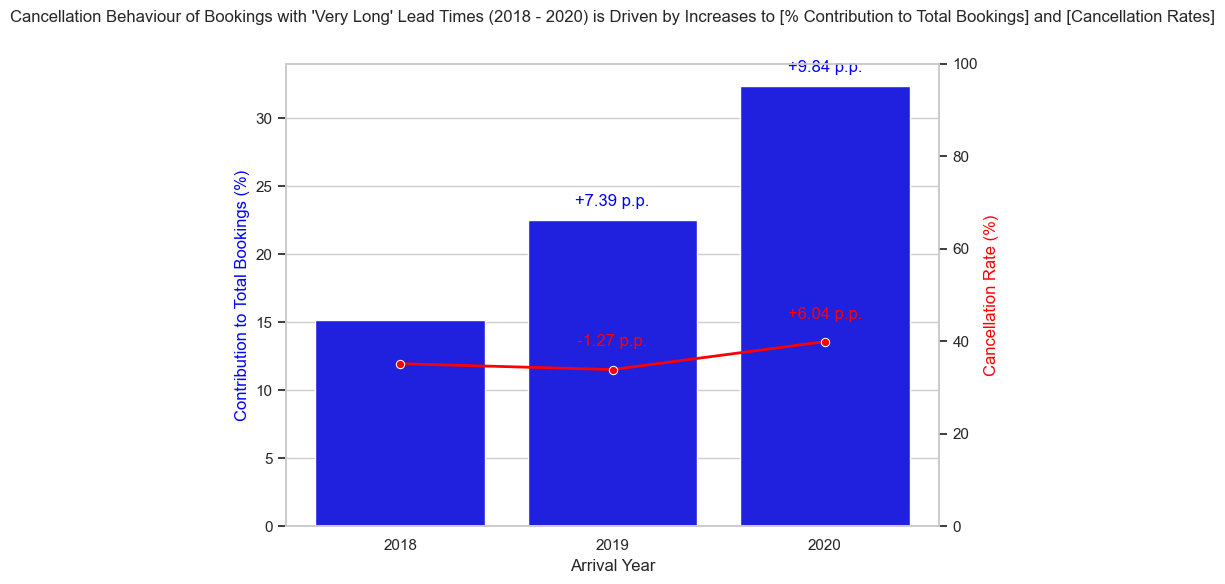

In [162]:
years_size = df_lead_grp_size_y_chart["arrival_date_year"]
values_size = df_lead_grp_size_y_chart["Very Long"]

# years_rate = 
values_rate = df_lead_grp_rate_y_chart["Very Long"]

sns.set_theme(style='whitegrid')

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot: % contribution to cancellations
sns.barplot(
    x= years_size, 
    y=values_size, 
    # data=df_lead_grp_size_y_chart, 
    ax=ax1, 
    color='blue', 
    label='Contribution to Total Bookings (%)',
    legend = False
)

for value in range(1, 3): # 1, 2
    diff = values_size.iloc[value] - values_size.iloc[value - 1]
    ax1.annotate(f'+{diff:.2f} p.p.',
             xy=(years_size.iloc[value], values_size.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
             xytext=(years_size.iloc[value], values_size.iloc[value] + 1), # specific positioning of text (x = '2020', y = value for 2020 + extra)
             ha='center',
             color = "blue") # horizontal alignment of text

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.grid(False)

# Line plot: cancellation rate
sns.lineplot(
    x=years_size, 
    y=values_rate, 
    # data=df_lead_grp_rate_y_chart, 
    ax=ax2, 
    color='red', 
    marker='o', 
    linewidth=2, 
    label='Cancellation Rate',
    legend = False
)

for value in range(1, 3): # 1, 2
    diff = values_rate.iloc[value] - values_rate.iloc[value - 1]
    if diff > 0:
        ax2.annotate(f'+{diff:.2f} p.p.',
                xy=(years_size.iloc[value], values_rate.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
                xytext=(years_size.iloc[value], values_rate.iloc[value] + 5), # specific positioning of text (x = '2020', y = value for 2020 + extra)
                ha='center',
                color = "Red") # horizontal alignment of text
    else:
        ax2.annotate(f'{diff:.2f} p.p.',
                xy=(years_size.iloc[value], values_rate.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
                xytext=(years.iloc[value], values_rate.iloc[value] + 5), # specific positioning of text (x = '2020', y = value for 2020 + extra)
                ha='center',
                color = "Red") # horizontal alignment of text

# Adjust the scale of the secondary y-axis
ax2.set_ylim(0, 100)

# Axis labels and title
ax1.set_xlabel("Arrival Year")
ax1.set_ylabel("Contribution to Total Bookings (%)", color='blue')
ax2.set_ylabel("Cancellation Rate (%)", color='red')
plt.title("Cancellation Behaviour of Bookings with 'Very Long' Lead Times (2018 - 2020) is Driven by Increases to [% Contribution to Total Bookings] and [Cancellation Rates]", pad = 30)

# Format and display
plt.tight_layout()
plt.savefig("06_long_ld_time_cancellation_factors.png", bbox_inches='tight')
plt.show()

The results of this sub-section add nuance by showing some signs of a year-effect that acts alongside the influence of lead-time on cancellation rate.<br>
As seasonal effects are either not apparent, or act in opposition to observed realities, this emphasises the relative important of group size (proportion per season represented) when it comes to the results by season.<br>
I.e. the volume of bookings from certain lead-time groups with certain inherent qualities is more important that the hypothetical influence of the season upon these groups

Overall then, we see these that lead-time can offer explanations to certain cancellation rate patterns over time:<br>
- Higher cancellation rate in Spring/Summer versus Aumumn/Winter owing to greater proportions of bookings have Long/Very Long lead-times (noting that generally, longer lead-time --> greater cancellation risk)
- Rising cancellation rates in the 'past 3 years' 2018 - 2020 owing both to these years containing rising proportional volumes of bookings with Very Long lead-times,<br>
and consistently rising cancellation rates for bookings with Long or Medium lead-times (rates for Very Long bookings increase too, but not monotonically).

All that said, offering long booking lead times is a benefit to customers, seen in how they form the majority of bookings overall.<br>
So long as the offering of long lead-times brings in more successful than failed bookings, which is the case since cancellation rate < 50%,<br>
presenting them as an option / encouraging them is worthwhile.<br>
(! Express in monetary terms?)<br><br>

The takeaways to be actioned are more around working around the cancellation tendencies  of such bookings, and trying to calm the rising trend therein, instead of discouraging the bookings entirely:<br>
1) Calibrate overbooking strategy: use latest data on cancellation rate from these lead-time groups to make occupancy planning more robust
2) Likewise for revenue forecasting
3) Try reducing cancellation risk through e.g. slight discounts or lock-in prices or room upgrades for choosing non-refundable bookings, more aggressive reminders to confirm bookings, etc.

## Market Segment vs Cancellation Rate

In [ ]:
df_seg_size = df_main.groupby("market_segment").size().reset_index().rename(columns = {0 : "bookings"})
total_bookings = len(df_main)
df_seg_size["segment_pc"] = df_seg_size["bookings"] / total_bookings
df_seg_size.sort_values(by = "segment_pc")

,market_segment,bookings,segment_pc
7,Undefined,6,0.00
1,Complementary,306,0.00
0,Aviation,446,0.00
2,Corporate,9104,0.05
4,Groups,10625,0.06
3,Direct,25207,0.14
5,Offline TA/TO,30159,0.16
6,Online TA,107551,0.59


As a primer, Online TA is by far the largest segment overall, and Offline TA and Direct are also rather sizeable

In [109]:
df_segment_cancellations = df_main.groupby("market_segment").size().reset_index().rename(columns = {0 : "bookings"})

df_segment_cancellations2 = df_main[["market_segment", "is_canceled"]].groupby("market_segment")["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})

df_segment_cancellations = df_segment_cancellations.merge(df_segment_cancellations2, on = "market_segment")

df_segment_cancellations["cancellation_rate"] = df_segment_cancellations["cancellations"] / df_segment_cancellations["bookings"]
df_segment_cancellations_basic = df_segment_cancellations[["market_segment", "cancellation_rate", "bookings", "cancellations"]].sort_values(by = "cancellation_rate", ascending = False)
df_segment_cancellations_basic

,market_segment,cancellation_rate,bookings,cancellations
7,Undefined,1.00,6,6
1,Complementary,0.60,306,184
6,Online TA,0.35,107551,37429
4,Groups,0.28,10625,2959
0,Aviation,0.20,446,90
3,Direct,0.15,25207,3762
5,Offline TA/TO,0.15,30159,4474
2,Corporate,0.12,9104,1127


At a glance, there are observations on relative cancellation rates across market segments that do make sense against prior known business logic:
- Complementary bookings involve less stake from the customer, freeing them to act in their own private interests
- Direct bookings tend to be demonstrative of greater intent, thus less likely cancellation
- Likewise when comaring offline vs online - online vendors make cancellation relatively easy; the notes from web sources at beginning of this section reflect that too
- Corporates too are more confident / cautious in their bookings, therefore cancel less often

It is easy to foresee that owing to its size and cancellation rate, that online TA is an important segment to look into.<br>
The 35% rate here is comparable to the previously listed figures for online cancellation rates, listed below as reminder:
- 38% (article published 2016)
- 2015 to 2018: 32.5%, 34.8%, 39.6%, 41.3%, 39.6%
- 2015: 19%
- 2023 Europe study: 31% from Expedia, 42% from Bookings Holdings

Naturally, it would be better to benchmark against internal history and expectations ...<br>
In any case, we can at least look into trend 2015 - 2020 and make judgement, as shall be done below:

In [110]:
# sns.set_theme(style="whitegrid")

# df_plot = df_segment_cancellations_basic[df_segment_cancellations_basic["market_segment"] != "Undefined"]

# # Create the bar plot
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=df_plot,
#                  x='market_segment',
#                  y='cancellation_rate',
#                  color='blue')

# # Percentage labels on top of bars
# for p in ax.patches: # list of bar objects in ax --> each 'p' is a bar in barplot
#     height = p.get_height()
#     ax.text(
#             p.get_x() + p.get_width() / 2, # get_x = left x position of bar, width = width, therefore overall this finds middle of bar - position text there)
#             height + 0.01, # move label above bar (top + a bit)
#             f"{height * 100:.1f}%", # 1 d.p.
#             ha='center', # horizontal alignment := position text box in centre of p.get_x() + p.get_width() / 2
#             va = 'bottom') # vertical alignment := position text box at bottom of 'height + 0.01'

# # Set labels and title
# plt.ylabel('Cancellation Rate (%)')
# plt.xlabel('Market Segment')
# plt.title('Cancellation Rate by Market Segment')
# plt.ylim(0, 1.1)
# plt.tight_layout()
# plt.show()

In [111]:
df_seg_ldtime = df_main.groupby("market_segment")["lead_time"].agg(["mean", "median"]).rename(columns = {"mean" : "mean lead_time", "median" : "median lead_time"})
df_seg_ldtime = df_seg_ldtime.merge(df_segment_cancellations_basic[["market_segment", "cancellation_rate"]], on = "market_segment")
df_seg_ldtime = df_seg_ldtime.sort_values(by = "cancellation_rate")
df_seg_ldtime

,market_segment,mean lead_time,median lead_time,cancellation_rate
2,Corporate,16.20,6.00,0.12
5,Offline TA/TO,104.33,80.00,0.15
3,Direct,47.91,15.00,0.15
0,Aviation,4.35,3.00,0.20
4,Groups,145.05,103.00,0.28
6,Online TA,78.31,54.00,0.35
1,Complementary,25.58,6.00,0.60
7,Undefined,1.50,1.50,1.00


In [112]:
df_seg_ldtmgrp_size = df_main.groupby(["market_segment", "lead_time_group"]).size().reset_index().rename(columns = {0 : "bookings"})
df_seg_ldtmgrp_size["seg_bookings"] = df_seg_ldtmgrp_size.groupby("market_segment")["bookings"].transform("sum")
df_seg_ldtmgrp_size["grp_pc"] = df_seg_ldtmgrp_size["bookings"] / df_seg_ldtmgrp_size["seg_bookings"]
df_seg_ldtmgrp_size_pvt = df_seg_ldtmgrp_size[["market_segment", "lead_time_group", "grp_pc"]]
df_seg_ldtmgrp_size_pvt = df_seg_ldtmgrp_size_pvt.pivot(index = "market_segment", columns = "lead_time_group", values = "grp_pc")
df_seg_ldtmgrp_size_pvt

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\35347078.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seg_ldtmgrp_size = df_main.groupby(["market_segment", "lead_time_group"]).size().reset_index().rename(columns = {0 : "bookings"})


lead_time_group,Last Minute,Short,Medium,Long,Very Long
market_segment,,,,,
Aviation,0.57,0.39,0.04,0.00,0.00
Complementary,0.41,0.25,0.17,0.13,0.04
Corporate,0.38,0.33,0.20,0.07,0.01
Direct,0.35,0.15,0.17,0.18,0.15
Groups,0.04,0.09,0.17,0.21,0.48
Offline TA/TO,0.07,0.10,0.18,0.29,0.36
Online TA,0.10,0.13,0.23,0.29,0.25
Undefined,1.00,0.00,0.00,0.00,0.00


There is little discernable pattern in terms of lead time by market segment (and each segment's cancellation rate),<br>
suggesting there are inherent properties of segments which affect their cancellation rate,<br>
or at least, that lead time is not a property of segments which affects their cancellation rate.

In [113]:
df_mkt_seg_ldtm_canc = df_main[df_main["market_segment"] != "Undefined"].groupby(["market_segment", "is_canceled"])["lead_time"].agg(["mean", "median"]).reset_index().rename(columns = {"mean" : "mean_lead_time", "median" : "median_lead_time"})
df_mkt_seg_ldtm_canc

,market_segment,is_canceled,mean_lead_time,median_lead_time
0,Aviation,0,4.17,3.00
1,Aviation,1,5.04,3.00
2,Complementary,0,37.06,10.50
3,Complementary,1,17.97,4.00
4,Corporate,0,14.19,5.00
5,Corporate,1,30.41,13.00
6,Direct,0,44.14,11.00
7,Direct,1,69.46,39.00
8,Groups,0,130.94,96.00
9,Groups,1,181.62,155.00


In [114]:
df_mkt_seg_ldtm_canc2 = df_mkt_seg_ldtm_canc[["market_segment", "is_canceled", "median_lead_time"]]
df_mkt_seg_ldtm_canc2_pvt = df_mkt_seg_ldtm_canc2.pivot(index='market_segment', columns='is_canceled', values='median_lead_time')
df_mkt_seg_ldtm_canc2_pvt.columns = ['median_not_cancelled', 'median_cancelled']  # is_canceled == 0 → not canceled, 1 → canceled
# df_mkt_seg_ldtm_canc2_pvt
df_mkt_seg_ldtm_canc2_pvt['pc_diff_median_lead_time'] = ((df_mkt_seg_ldtm_canc2_pvt['median_cancelled'] - df_mkt_seg_ldtm_canc2_pvt['median_not_cancelled']) / df_mkt_seg_ldtm_canc2_pvt['median_not_cancelled'])

df_mkt_seg_ldtm_canc2 = df_mkt_seg_ldtm_canc2.merge(df_mkt_seg_ldtm_canc2_pvt[['pc_diff_median_lead_time']], on="market_segment")

df_mkt_seg_ldtm_canc2 = df_mkt_seg_ldtm_canc2[["market_segment", "pc_diff_median_lead_time"]].drop_duplicates().copy()
df_mkt_seg_ldtm_canc2["pc_diff_median_lead_time"] *= 100
df_mkt_seg_ldtm_canc2


,market_segment,pc_diff_median_lead_time
0,Aviation,0.00
2,Complementary,-61.90
4,Corporate,160.00
6,Direct,254.55
8,Groups,61.46
10,Offline TA/TO,50.00
12,Online TA,97.50


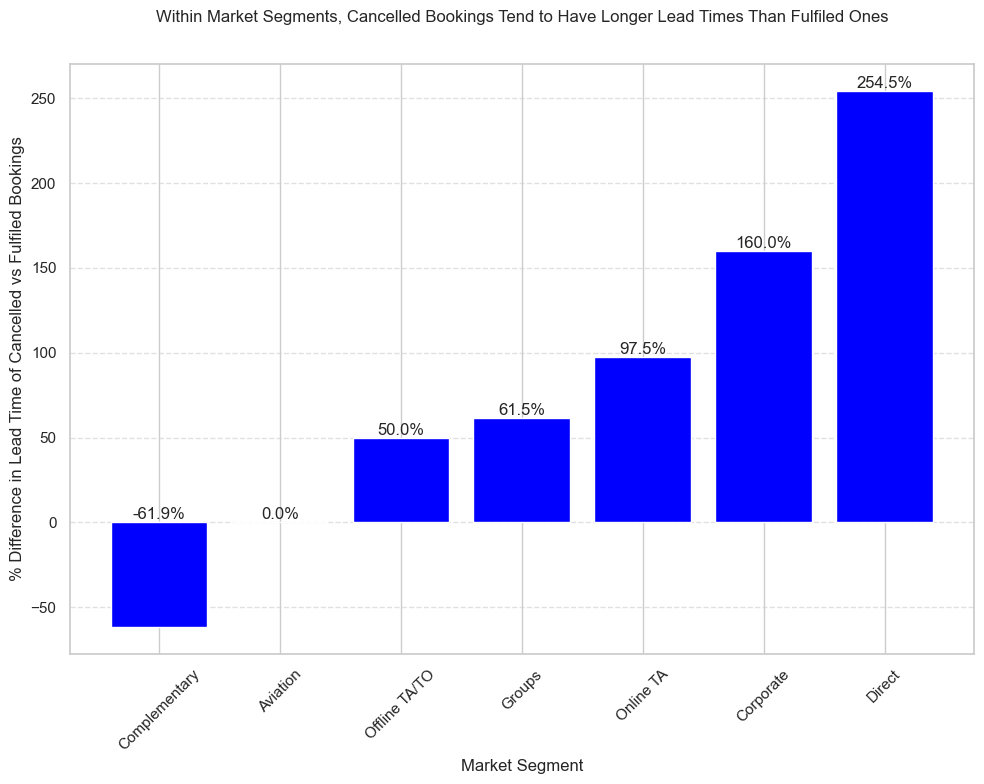

In [163]:
df_mkt_seg_ldtm_canc2 = df_mkt_seg_ldtm_canc2.sort_values('pc_diff_median_lead_time', ascending=True)

# Plot
plt.figure(figsize=(10, 8))
bars = plt.bar(df_mkt_seg_ldtm_canc2['market_segment'], df_mkt_seg_ldtm_canc2['pc_diff_median_lead_time'], color='blue')

# Add value labels on top of bars (FIX)
for bar in bars:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1f}%", ha='center', va='bottom')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, 0, f"{yval:.1f}%", ha='center', va='bottom')

# Titles and labels
plt.title('Within Market Segments, Cancelled Bookings Tend to Have Longer Lead Times Than Fulfiled Ones', pad = 30)
plt.ylabel('% Difference in Lead Time of Cancelled vs Fulfiled Bookings')
plt.xlabel('Market Segment')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("07_mkt_seg_ld_time_vs_cancel_rate.png", bbox_inches='tight')
plt.show()

Controlling for market segment however, it is observable that cancelled bookings have on average longer lead times.<br>
Except for the Complementary segment, which firstly is rather small so probably negligible anyway,<br>
and secondly probably has unique characteristics like mandating stipulated dates not planned for by customers (speculation - needs confirmation).<br>
Therefore, there continues to be evidence that lead time affects cancellation rate, but independently, market segment also has influence (perhaps directly, perhaps through some other channel)

In [116]:
df_mkt_seg_szn_size = df_main.groupby(["market_segment"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})
df_mkt_seg_szn_size["total_cancellations"] = sum(df_mkt_seg_szn_size["cancellations"])
df_mkt_seg_szn_size["cancellations_pc"] = (df_mkt_seg_szn_size["cancellations"] / df_mkt_seg_szn_size["total_cancellations"]) * 100
df_mkt_seg_szn_size

,market_segment,cancellations,total_cancellations,cancellations_pc
0,Aviation,90,50031,0.18
1,Complementary,184,50031,0.37
2,Corporate,1127,50031,2.25
3,Direct,3762,50031,7.52
4,Groups,2959,50031,5.91
5,Offline TA/TO,4474,50031,8.94
6,Online TA,37429,50031,74.81
7,Undefined,6,50031,0.01


In [117]:
df_mkt_seg_szn_size_chart = df_mkt_seg_szn_size[["market_segment", "cancellations_pc"]]
df_mkt_seg_szn_size_chart["mkt_seg_chart"] = df_mkt_seg_szn_size_chart["market_segment"].apply(
    lambda x: "Online TA" if x == "Online TA" else "Not Online TA"
)

online_canc_pc = df_mkt_seg_szn_size_chart[df_mkt_seg_szn_size_chart['mkt_seg_chart'] == "Online TA"]['cancellations_pc'].sum()

offline_canc_pc = df_mkt_seg_szn_size_chart[df_mkt_seg_szn_size_chart['mkt_seg_chart'] != "Online TA"]['cancellations_pc'].sum()

df_mkt_seg_szn_size_chart["canc_pc_chart"] = df_mkt_seg_szn_size_chart["market_segment"].apply(
    lambda x: online_canc_pc if x == "Online TA" else offline_canc_pc
)

df_mkt_seg_szn_size_chart = df_mkt_seg_szn_size_chart[["mkt_seg_chart", "canc_pc_chart"]].rename(columns = {"mkt_seg_chart" : "market_segment", "canc_pc_chart" : "cancellations_pc"})
df_mkt_seg_szn_size_chart = df_mkt_seg_szn_size_chart.drop_duplicates().copy().reset_index(drop = True)
df_mkt_seg_szn_size_chart

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\4137830409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mkt_seg_szn_size_chart["mkt_seg_chart"] = df_mkt_seg_szn_size_chart["market_segment"].apply(


,market_segment,cancellations_pc
0,Not Online TA,25.19
1,Online TA,74.81


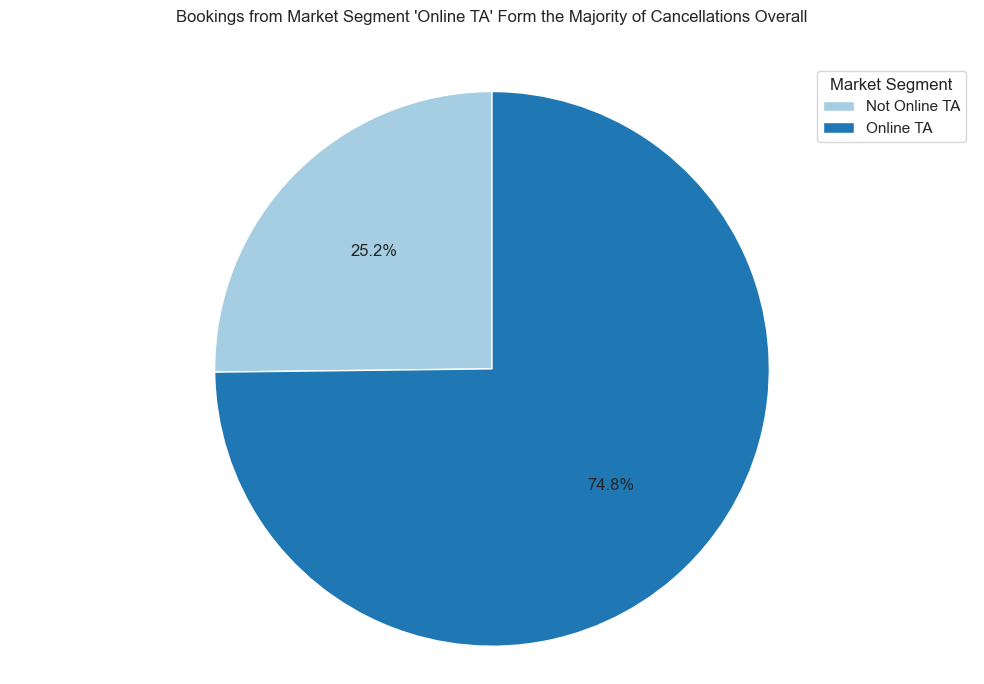

In [164]:
# Data
labels = df_mkt_seg_szn_size_chart['market_segment']
sizes = df_mkt_seg_szn_size_chart['cancellations_pc']

# Plot
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct=lambda pct: f'{pct:.1f}%',
    startangle=90,
    colors=plt.cm.Paired.colors
)

# Legend
plt.legend(wedges, labels, title='Market Segment', loc='upper right')

# Make the pie a circle
plt.axis('equal')
plt.title("Bookings from Market Segment 'Online TA' Form the Majority of Cancellations Overall", pad = 30)
plt.tight_layout()
plt.savefig("08_mkt_seg_vs_cancel_size.png", bbox_inches='tight')
plt.show()

Being the largest segment by booking volume, and relatively high in cancellation rate, Online TA thus amounts to the majority of cancellations overall

In [119]:
# df_mkt_seg_szn_size = df_main.groupby(["season", "market_segment"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})
# df_mkt_seg_szn_size["szn_cancellations"] = df_mkt_seg_szn_size.groupby("season")["cancellations"].transform("sum")
# df_mkt_seg_szn_size["cancellations_pc_per_szn"] = df_mkt_seg_szn_size["cancellations"] / df_mkt_seg_szn_size["szn_cancellations"] 
# df_mkt_seg_szn_size_pvt = df_mkt_seg_szn_size[["season", "market_segment", "cancellations_pc_per_szn"]]
# df_mkt_seg_szn_size_pvt = df_mkt_seg_szn_size_pvt.pivot(index = "season", columns = "market_segment", values = "cancellations_pc_per_szn")
# df_mkt_seg_szn_size_pvt

Edit: a bit obvious / low value
<!-- Consistently across seasons, the dominance of Online TA in terms of contribution to percent of time-period cancellations is clear.<br> -->

In [120]:
df_mkt_seg_y_size = df_main.groupby(["arrival_date_year", "market_segment"])["is_canceled"].sum().reset_index().rename(columns = {"is_canceled" : "cancellations"})
df_mkt_seg_y_size["y_cancellations"] = df_mkt_seg_y_size.groupby("arrival_date_year")["cancellations"].transform("sum")
df_mkt_seg_y_size["cancellations_pc_per_y"] = df_mkt_seg_y_size["cancellations"] / df_mkt_seg_y_size["y_cancellations"] 
df_mkt_seg_y_size_pvt = df_mkt_seg_y_size[["arrival_date_year", "market_segment", "cancellations_pc_per_y"]]
df_mkt_seg_y_size_pvt = df_mkt_seg_y_size_pvt.pivot(index = "arrival_date_year", columns = "market_segment", values = "cancellations_pc_per_y")
df_mkt_seg_y_size_pvt *= 100
df_mkt_seg_y_size_pvt

market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA,Undefined
arrival_date_year,,,,,,,,
2015,NaN,0.52,4.14,11.21,13.98,16.65,53.42,0.07
2016,0.21,0.38,2.02,6.94,4.60,8.64,77.20,NaN
2017,0.21,0.28,1.69,6.50,4.34,6.32,80.66,NaN
2018,NaN,0.52,4.16,11.22,13.64,16.72,53.66,0.07
2019,0.17,0.41,2.43,7.77,6.35,10.21,72.64,0.01
2020,0.22,0.30,1.78,6.82,4.00,5.81,81.06,NaN


In [121]:
df_mkt_seg_y_size_chart = df_mkt_seg_y_size_pvt.loc[[2018, 2019, 2020], ["Online TA"]].reset_index()
df_mkt_seg_y_size_chart

market_segment,arrival_date_year,Online TA
0,2018,53.66
1,2019,72.64
2,2020,81.06


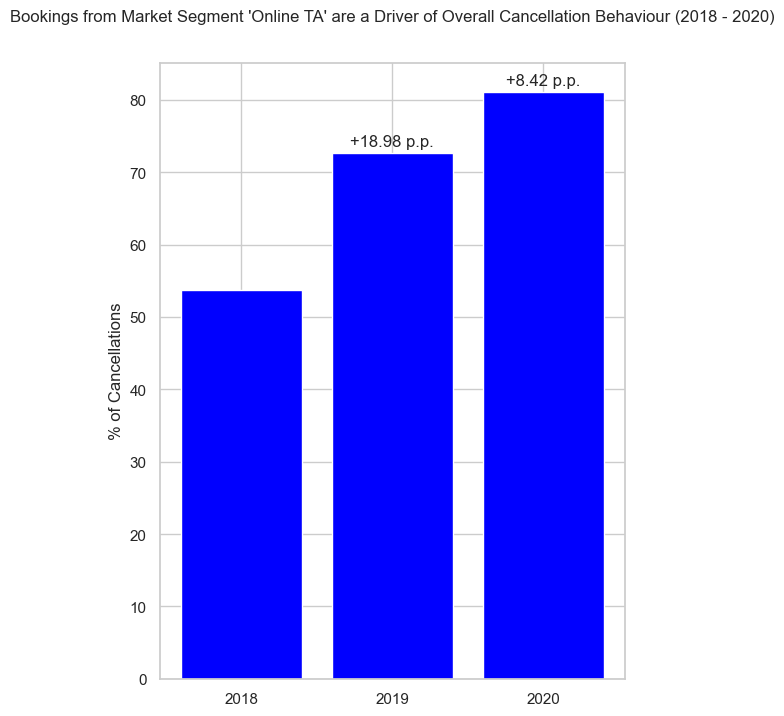

In [167]:

years = df_mkt_seg_y_size_chart["arrival_date_year"].astype(str) # otherwise gets treated as continuous number (decimals)
values = df_mkt_seg_y_size_chart["Online TA"]

plt.figure(figsize = (6, 8))
plt.bar(years, values, color = "blue")
plt.title("Bookings from Market Segment 'Online TA' are a Driver of Overall Cancellation Behaviour (2018 - 2020)", pad = 30)
plt.ylabel('% of Cancellations')
# plt.ylim(0, 50)

for value in range(1, 3): # 1, 2
    diff = values.iloc[value] - values.iloc[value - 1]
    plt.annotate(f'+{diff:.2f} p.p.',
             xy=(years.iloc[value], values.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
             xytext=(years.iloc[value], values.iloc[value] + 1), # specific positioning of text (x = '2020', y = value for 2020 + extra)
             ha='center') # horizontal alignment of text
plt.savefig("09_onlineTA_driving_cancellations.png", bbox_inches='tight')
plt.show()

The continual increase in cancellation rate between 2018 - 2020 was driven mostly by Online TA, which constantly increased its percentage share of per-year cancellations in that time period

In [123]:
df_mkt_seg_rev = df_main_cancelled[df_main_cancelled["deposit_type"] != "Non Refund"].groupby("market_segment")["booking_revenue"].sum().reset_index().rename(columns = {"booking_revenue" : "lost_revenue"})
df_mkt_seg_rev["lost_revenue_total"] = sum(df_mkt_seg_rev["lost_revenue"])
df_mkt_seg_rev["pc_lost_revenue"] = df_mkt_seg_rev["lost_revenue"] / df_mkt_seg_rev["lost_revenue_total"]
df_mkt_seg_rev

,market_segment,lost_revenue,lost_revenue_total,pc_lost_revenue
0,Aviation,28130.00,23220572.52,0.00
1,Complementary,651.97,23220572.52,0.00
2,Corporate,216025.96,23220572.52,0.01
3,Direct,1994173.38,23220572.52,0.09
4,Groups,370715.77,23220572.52,0.02
5,Offline TA/TO,1620425.01,23220572.52,0.07
6,Online TA,18990306.43,23220572.52,0.82
7,Undefined,144.00,23220572.52,0.00


In [124]:
# repeat revenue analysis by szn and by yr if it helps illustrate a point

Going by (potential) financial impact of cancellations, Online TA is, as expected, the most important segment

Note that the revenue from these cancellations is not necessarily 'lost' - reasonable to assume the Hotel can find replacements, perhaps even with an existing overbooking system.<br>
Regardless, might disrupt customer-level behaviours (e.g. urgency if a room type is 'selling fast'), increases variance in forecasting, etc. (research more).<br>
Whatever the precise case, this is just a starting point for inquiries.

In [125]:
# df_ltg_rev_szn = df_main_cancelled[df_main_cancelled["deposit_type"] != "Non Refund"].groupby(["season", "lead_time_group"])["booking_revenue"].sum().reset_index().rename(columns = {"booking_revenue" : "lost_revenue"})
# df_ltg_rev_szn["lost_revenue_szn"] = df_ltg_rev_szn.groupby("season")["lost_revenue"].transform("sum")
# df_ltg_rev_szn["grp_pc"] = df_ltg_rev_szn["lost_revenue"] / df_ltg_rev_szn["lost_revenue_szn"]

# # df_ltg_rev_szn["pc_lost_revenue"] = df_ltg_rev_szn["lost_revenue"] / df_ltg_rev_szn["lost_revenue_total"]
# df_ltg_rev_szn_pvt = df_ltg_rev_szn[["season", "lead_time_group", "grp_pc"]]
# df_ltg_rev_szn_pvt = df_ltg_rev_szn_pvt.pivot(index = "season", columns = "lead_time_group", values = "grp_pc")
# df_ltg_rev_szn_pvt

... See lead-time analysis - this framework doesn't make sense

In [126]:
# df_ltg_rev_y = df_main_cancelled[df_main_cancelled["deposit_type"] != "Non Refund"].groupby(["arrival_date_year", "lead_time_group"])["booking_revenue"].sum().reset_index().rename(columns = {"booking_revenue" : "lost_revenue"})
# df_ltg_rev_y["lost_revenue_y"] = df_ltg_rev_y.groupby("arrival_date_year")["lost_revenue"].transform("sum")
# df_ltg_rev_y["grp_pc"] = df_ltg_rev_y["lost_revenue"] / df_ltg_rev_y["lost_revenue_y"]

# # df_ltg_rev_y["pc_lost_revenue"] = df_ltg_rev_y["lost_revenue"] / df_ltg_rev_y["lost_revenue_total"]
# df_ltg_rev_y_pvt = df_ltg_rev_y[["arrival_date_year", "lead_time_group", "grp_pc"]]
# df_ltg_rev_y_pvt = df_ltg_rev_y_pvt.pivot(index = "arrival_date_year", columns = "lead_time_group", values = "grp_pc")
# df_ltg_rev_y_pvt

... See lead-time analysis - this framework doesn't make sense

In [127]:
df_mkt_seg_szn = df_main.groupby(["season", "market_segment"]).size().reset_index().rename(columns = {0 : "bookings"})
df_mkt_seg_szn["szn_bookings"] = df_mkt_seg_szn.groupby("season")["bookings"].transform("sum")
df_mkt_seg_szn["group_pc"] = df_mkt_seg_szn["bookings"] / df_mkt_seg_szn["szn_bookings"]
df_mkt_seg_szn = df_mkt_seg_szn.sort_values(by = ["season", "market_segment"])
df_mkt_seg_szn_pvt = df_mkt_seg_szn[["season", "market_segment", "group_pc"]]
df_mkt_seg_szn_pvt = df_mkt_seg_szn_pvt.pivot(index = "season", columns = "market_segment", values = "group_pc")
df_mkt_seg_szn_pvt

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\1127914719.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mkt_seg_szn = df_main.groupby(["season", "market_segment"]).size().reset_index().rename(columns = {0 : "bookings"})
C:\Users\danie\AppData\Local\Temp\ipykernel_15912\1127914719.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mkt_seg_szn["szn_bookings"] = df_mkt_seg_szn.groupby("season")["bookings"].transform("sum")


market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA,Undefined
season,,,,,,,,
spring,0.01,0.00,0.04,0.12,0.06,0.15,0.62,0.00
summer,0.00,0.00,0.03,0.15,0.04,0.16,0.62,0.00
autumn,0.00,0.00,0.08,0.13,0.09,0.19,0.50,0.00
winter,0.00,0.00,0.07,0.16,0.05,0.15,0.57,0.00


In the relatively higher cancellation rate seasons of Spring/Summer, Online TA made up a greater % of overall bookings


In [128]:
df_mkt_seg_y = df_main.groupby(["arrival_date_year", "market_segment"]).size().reset_index().rename(columns = {0 : "bookings"})
df_mkt_seg_y["y_bookings"] = df_mkt_seg_y.groupby("arrival_date_year")["bookings"].transform("sum")
df_mkt_seg_y["group_pc"] = df_mkt_seg_y["bookings"] / df_mkt_seg_y["y_bookings"]
df_mkt_seg_y = df_mkt_seg_y.sort_values(by = ["arrival_date_year", "market_segment"])
df_mkt_seg_y_pvt = df_mkt_seg_y[["arrival_date_year", "market_segment", "group_pc"]]
df_mkt_seg_y_pvt = df_mkt_seg_y_pvt.pivot(index = "arrival_date_year", columns = "market_segment", values = "group_pc")
df_mkt_seg_y_pvt *= 100
df_mkt_seg_y_pvt

market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA,Undefined
arrival_date_year,,,,,,,,
2015,NaN,0.18,6.44,16.34,9.74,23.59,43.70,0.02
2016,0.29,0.19,5.02,12.57,4.73,16.75,60.46,NaN
2017,0.33,0.12,3.91,13.64,4.85,11.67,65.47,NaN
2018,NaN,0.18,6.44,16.35,9.66,23.61,43.74,0.02
2019,0.22,0.19,5.38,13.39,5.88,18.30,56.64,0.00
2020,0.34,0.13,3.98,13.90,4.76,11.63,65.27,NaN


In [129]:
df_mkt_seg_size_y_chart = df_mkt_seg_y_pvt.loc[[2018, 2019, 2020], ["Online TA"]].reset_index()
df_mkt_seg_size_y_chart["arrival_date_year"] = df_mkt_seg_size_y_chart["arrival_date_year"].astype(str) # otherwise gets treated as continuous number (decimals)
df_mkt_seg_size_y_chart

market_segment,arrival_date_year,Online TA
0,2018,43.74
1,2019,56.64
2,2020,65.27


In [130]:
# Chart 2018 - 2020 increase in percentage contribution of Online TA to per-year bookings
# Not really needed as final chart combines this with rate

In the relatively higher cancellation rate years 2017 and 2020, Online TA made up a greater % of overall bookings.<br>
Vice versa for 2015/2018

As with lead-time, there remain questions over directionality: the inherent cancellation rate of Online TA might be exaggerated due to over-representation in high-cancellation time periods.<br>
So, as before, look at cancellation rates per segment over time

In [131]:
df_main.groupby(['market_segment', 'season'])['is_canceled'].mean().unstack()

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\666176385.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_main.groupby(['market_segment', 'season'])['is_canceled'].mean().unstack()


season,spring,summer,autumn,winter
market_segment,,,,
Aviation,0.21,0.24,0.18,0.11
Complementary,0.76,0.65,0.57,0.50
Corporate,0.12,0.21,0.11,0.08
Direct,0.15,0.17,0.15,0.11
Groups,0.28,0.36,0.23,0.27
Offline TA/TO,0.16,0.17,0.13,0.11
Online TA,0.36,0.37,0.30,0.33
Undefined,NaN,1.00,NaN,NaN


Gentle evidence of a seasonal effect, specifically that cancellation rates are naturally higher in the Summer:
- Highest rate season across all segemnts, except for Complementary, which is so small as to be unreliable anyway
- This matches what was seen in the time and lead-time analyses<br><br>

Slight evidence supporting the idea that Spring has a higher inherent cancellation rate than Autumn,<br>
which, is a reminder, was relevant to distinguishing whether cancellation rates were lower in 2015/2018 due to year or seasonal factors.<br><br>

We might even say that Spring/Summer are distinctly higher-cancellation periods than Autumn/Winter,<br>
especially looking at the two largest segments Online TA and Offline TA.<br><br>

All told though, these are just cursory inferences based on directionality, and again a full-on statistical test would optimal for confident inferences.<br>
This is just to suggest / motivate doing such test(s), rather than a conclusive declaration.<br>
For now, take it as a light suggestion of a seasonal effect

In [132]:
# df_mkt_seg_rate = df_main.groupby(['market_segment', 'arrival_date_year'])['is_canceled'].mean().unstack()
df_mkt_seg_rate_y = df_main.groupby(['market_segment', 'arrival_date_year'])['is_canceled'].mean().reset_index().rename(columns = {"is_canceled" : "cancellation_rate"})
df_mkt_seg_rate_y = df_mkt_seg_rate_y.pivot(index = "arrival_date_year", columns = "market_segment", values = "cancellation_rate")
df_mkt_seg_rate_y *= 100
df_mkt_seg_rate_y

market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA,Undefined
arrival_date_year,,,,,,,,
2015,NaN,60.87,13.53,14.41,30.17,14.83,25.69,100.00
2016,20.17,53.75,10.82,14.87,26.20,13.89,34.38,NaN
2017,20.19,71.79,13.98,15.39,28.90,17.50,39.78,NaN
2018,NaN,60.87,13.53,14.37,29.55,14.83,25.69,100.00
2019,20.17,55.88,11.59,14.88,27.67,14.31,32.89,100.00
2020,20.19,71.79,13.77,15.13,25.93,15.42,38.29,NaN


In [133]:
df_mkt_seg_rate_y_chart = df_mkt_seg_rate_y.loc[[2018, 2019, 2020], ["Online TA"]].reset_index()
df_mkt_seg_rate_y_chart["arrival_date_year"] = df_lead_grp_rate_y_chart["arrival_date_year"].astype(str) # otherwise gets treated as continuous number (decimals)
df_mkt_seg_rate_y_chart

market_segment,arrival_date_year,Online TA
0,2018,25.69
1,2019,32.89
2,2020,38.29


In [134]:
# Chart using df_mkt_seg_rate_y_chart
# Not needed as final chart shows both bookings and rates for Online TA in one

Year doesn't seem to have much influence over the cancellation liability of segments.<br><br>

Except: crucially though, Online TA has increased in cancellation rate steadily 2015-2017 and 2018-2020, matching the overall pattern of increased cancellation rates in cycles of three years.<br><br>

Therefore, cancellation rate of Online TA, alongside increased number of bookings from this segment, as found above, is a driver of the results seen.<br>
The importance of Online TA is all the more apparent when considering the behaviour of segment 'Groups', which had the second-highest overall cancellation rate amongst segments:<br>
it did not adhere to the obserbed year-patterns of cancellations - neither through cancellation rate per year, nor presence (size) per year.<br>
In fact, for size, it actually fell in 2017/2020.

Not only do Online TA bookings fall in cancellation rate in Autumn/Winter, but they also represent proportionally less of (count of) cancellations in these seasons as compared to Summer/Spring

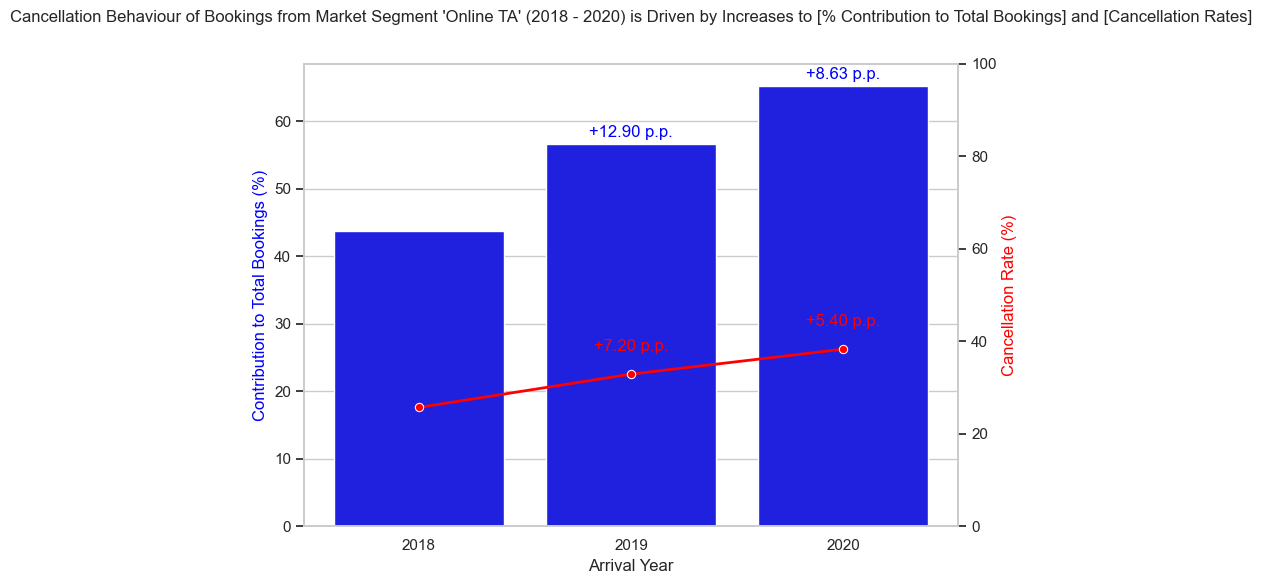

In [168]:
years_size_ms = df_mkt_seg_size_y_chart["arrival_date_year"]
values_size_ms = df_mkt_seg_size_y_chart["Online TA"]

# years_rate = 
values_rate_ms = df_mkt_seg_rate_y_chart["Online TA"]

sns.set_theme(style='whitegrid')

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot: % contribution to cancellations
sns.barplot(
    x= years_size_ms, 
    y=values_size_ms, 
    # data=df_lead_grp_size_y_chart, 
    ax=ax1, 
    color='blue', 
    label='Contribution to Total Bookings (%)',
    legend = False
)

for value in range(1, 3): # 1, 2
    diff = values_size_ms.iloc[value] - values_size_ms.iloc[value - 1]
    ax1.annotate(f'+{diff:.2f} p.p.',
             xy=(years_size_ms.iloc[value], values_size_ms.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
             xytext=(years_size_ms.iloc[value], values_size_ms.iloc[value] + 1), # specific positioning of text (x = '2020', y = value for 2020 + extra)
             ha='center',
             color = "blue") # horizontal alignment of text

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.grid(False)

# Line plot: cancellation rate
sns.lineplot(
    x=years_size_ms, 
    y=values_rate_ms, 
    # data=df_lead_grp_rate_y_chart, 
    ax=ax2, 
    color='red', 
    marker='o', 
    linewidth=2, 
    label='Cancellation Rate',
    legend = False
)

for value in range(1, 3): # 1, 2
    diff = values_rate_ms.iloc[value] - values_rate_ms.iloc[value - 1]
    if diff > 0:
        ax2.annotate(f'+{diff:.2f} p.p.',
                xy=(years_size_ms.iloc[value], values_rate_ms.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
                xytext=(years_size_ms.iloc[value], values_rate_ms.iloc[value] + 5), # specific positioning of text (x = '2020', y = value for 2020 + extra)
                ha='center',
                color = "Red") # horizontal alignment of text
    else:
        ax2.annotate(f'{diff:.2f} p.p.',
                xy=(years_size_ms.iloc[value], values_rate_ms.iloc[value]), # positioning of annotation (x = '2020', y = value for 2020 i.e. top of bar)
                xytext=(years.iloc[value], values_rate_ms.iloc[value] + 5), # specific positioning of text (x = '2020', y = value for 2020 + extra)
                ha='center',
                color = "Red") # horizontal alignment of text

# Adjust the scale of the secondary y-axis
ax2.set_ylim(0, 100)

# Axis labels and title
ax1.set_xlabel("Arrival Year")
ax1.set_ylabel("Contribution to Total Bookings (%)", color='blue')
ax2.set_ylabel("Cancellation Rate (%)", color='red')
plt.title("Cancellation Behaviour of Bookings from Market Segment 'Online TA' (2018 - 2020) is Driven by Increases to [% Contribution to Total Bookings] and [Cancellation Rates]", pad = 30)

# Format and display
plt.tight_layout()
plt.savefig("10_onlineTA_rate_and_bk_vol_increase.png", bbox_inches='tight')
plt.show()

The takeaways and insights for market segment analysis are quite similar to those of lead times,<br>
in that there is a prominent entity (online TA bookings, long lead-time bookings) which are rising in contribution to overall yearly cancellations,<br>
this itself a result of that entity increasing in contribution to overall yearly bookings, and having an increasing cancellation rate.<br>
Furthermore, they both represent 'modern' bookings perks which are attractive to customers (they are popular aspects of placing bookings),<br>
and as of now, more bookings are fulfiled than not, so in neither case is it adviseable to steer away from them by offering only short-notice, offline / online but not TA bookings.<br><br>

The action points for the business are therefore similar:
1) Encourage customers to take on non-cancellable bookings even if using Online TA by locking in slightly lower prices if non-refundable, for instance.
2) Drill down into which specific Online TA are most culpable and plan bespoke mitigation strategies
3) Factor in a rising cancellation rate trend into overbooking systems if they exist

### Insight: Online TA + Lead-time Analysis

<!-- We have established some key observations in the previous section:

- (1) Higher lead time tends to mean higher cancellation rate, controlling for year, season, market segment
- (2) Online TA is a key market segment, as it is the largest by representation amongst bookings,<br>
and has the highest cancellation rate of any significantly sized segment.
- (3) Because long and very-long lead-time bookings, and Online TA bookings represent a lesser proportion of bookings in Autumn/Winter<br>
than they do in Spring/Summer, this makes those seasons relatively lower / higher in cancellation rate.<br>
Thus there should be heightened awareness of cancellation liability by (very) early online bookings due for Autumn/Winter,<br>
and preparations in place to anticipate these bookings dropping out.<br>
Perhaps even a modified (more ambitious) overbooking strategy in place for these seasons. -->

Having established lead time and market segment to be important factors of cancellation rate patterns observed,<br>
especially bookings with longer lead times and market segment 'Online TA'<br>
would be good to hone in on behaviour of the lead time of bookings with these qualities (Online TA _and_ long lead time)


In [136]:
df_online = df_main[df_main["market_segment"] == "Online TA"]

df_online.groupby("market_segment").size()

market_segment
Online TA    107551
dtype: int64

In [137]:
df_online.groupby(['market_segment', 'season'])['is_canceled'].mean().unstack()

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\2848650919.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_online.groupby(['market_segment', 'season'])['is_canceled'].mean().unstack()


season,spring,summer,autumn,winter
market_segment,,,,
Online TA,0.36,0.37,0.30,0.33


In [138]:
df_online.groupby('season')["lead_time"].agg(["mean", "median"])

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\240144970.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_online.groupby('season')["lead_time"].agg(["mean", "median"])


,mean,median
season,,
spring,81.27,65.00
summer,99.09,83.00
autumn,60.36,37.00
winter,50.22,28.00


Again there is evidence that lead time impacts cancellation rate: seasons with higher cancellation rate for online bookings have longer average lead times

In [139]:
df_online.groupby(["arrival_date_year", 'season'])['lead_time'].mean().unstack()

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\1012392413.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_online.groupby(["arrival_date_year", 'season'])['lead_time'].mean().unstack()


season,spring,summer,autumn,winter
arrival_date_year,,,,
2015,NaN,58.26,39.05,49.62
2016,63.51,97.16,72.09,45.21
2017,96.72,128.00,NaN,54.77
2018,NaN,58.26,39.05,49.62
2019,63.64,87.00,63.02,45.24
2020,94.42,125.65,NaN,54.60


At a year-season level, again lead times impact cancellation rate within online segment.<br><br>

Crucially, note how in 2018 - 2020, there is a constant within-season increase in lead time.<br>
This could be an explanatory factor for the increasing cancellation rate of Online bookings in this time period.<br><br>

In [156]:
df_online.groupby(["arrival_date_year", 'season'])['lead_time'].median().unstack()

C:\Users\danie\AppData\Local\Temp\ipykernel_15912\1923027342.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_online.groupby(["arrival_date_year", 'season'])['lead_time'].median().unstack()


season,spring,summer,autumn,winter
arrival_date_year,,,,
2015,NaN,38.00,23.00,39.00
2016,54.00,85.00,47.00,23.00
2017,79.00,128.00,NaN,32.00
2018,NaN,38.00,23.00,39.00
2019,54.00,69.00,40.00,24.00
2020,76.00,124.00,NaN,31.00


Generally see same thing with median as mean (... choose one or both to present)

In [169]:
# repeat above for year-level:
df_online.groupby(["arrival_date_year"])['lead_time'].agg(['mean', 'median']).reset_index()

,arrival_date_year,mean,median
0,2015,50.03,31.00
1,2016,73.32,52.00
2,2017,97.03,73.00
3,2018,50.03,31.00
4,2019,69.10,47.00
5,2020,95.43,71.00


In [158]:
# etc.

In [153]:
# df_not_online = df_main[df_main["market_segment"] != "Online TA"]

# df_not_online.groupby("market_segment").size()

In [143]:
# df_online_vs_online_canc_size = df_online[df_online["is_canceled"] == 1].groupby(["arrival_date_year", "season"]).size().reset_index().rename(columns = {0 : "cancellation_online"})
# df_online_vs_online_canc_size2 = df_not_online[df_not_online["is_canceled"] == 1].groupby(["arrival_date_year", "season"]).size().reset_index().rename(columns = {0 : "cancellation_not_online"})
# df_online_vs_online_canc_size = df_online_vs_online_canc_size.merge(df_online_vs_online_canc_size2, on = ["arrival_date_year", "season"])
# df_online_vs_online_canc_size["cancellations_total"] = df_online_vs_online_canc_size["cancellation_not_online"] + df_online_vs_online_canc_size["cancellation_online"]
# df_online_vs_online_canc_size["cancellation_pc_online"] = df_online_vs_online_canc_size["cancellation_online"] / df_online_vs_online_canc_size["cancellations_total"]
# df_online_vs_online_canc_size = df_online_vs_online_canc_size[["arrival_date_year", "season", "cancellation_pc_online"]]
# df_online_vs_online_canc_size

In [151]:
# df_online_vs_online_canc_size_y = df_online[df_online["is_canceled"] == 1].groupby(["arrival_date_year"]).size().reset_index().rename(columns = {0 : "cancellation_online"})
# df_online_vs_online_canc_size_y2 = df_not_online[df_not_online["is_canceled"] == 1].groupby(["arrival_date_year"]).size().reset_index().rename(columns = {0 : "cancellation_not_online"})
# df_online_vs_online_canc_size_y = df_online_vs_online_canc_size_y.merge(df_online_vs_online_canc_size_y2, on = ["arrival_date_year"])
# df_online_vs_online_canc_size_y["cancellations_total"] = df_online_vs_online_canc_size_y["cancellation_not_online"] + df_online_vs_online_canc_size_y["cancellation_online"]
# df_online_vs_online_canc_size_y["cancellation_pc_online"] =  df_online_vs_online_canc_size_y["cancellation_online"] / df_online_vs_online_canc_size_y["cancellations_total"]
# df_online_vs_online_canc_size_y = df_online_vs_online_canc_size_y[["arrival_date_year", "cancellation_pc_online"]]
# df_online_vs_online_canc_size_y

An even clearer look at outcomes: the ebbs and flows of cancellation rate over years are driven by Online TA primarily,<br>
in that during lower cancellation years, lesser % of cancellations originate from online TA, vice versa.

In [152]:
# df_online_vs_online_canc_size_szn = df_online[df_online["is_canceled"] == 1].groupby(["season"]).size().reset_index().rename(columns = {0 : "cancellation_online"})
# df_online_vs_online_canc_size_szn2 = df_not_online[df_not_online["is_canceled"] == 1].groupby(["season"]).size().reset_index().rename(columns = {0 : "cancellation_not_online"})
# df_online_vs_online_canc_size_szn = df_online_vs_online_canc_size_szn.merge(df_online_vs_online_canc_size_szn2, on = ["season"])
# df_online_vs_online_canc_size_szn["cancellations_total"] = df_online_vs_online_canc_size_szn["cancellation_not_online"] + df_online_vs_online_canc_size_szn["cancellation_online"]
# df_online_vs_online_canc_size_szn["cancellation_pc_online"] =  df_online_vs_online_canc_size_szn["cancellation_online"] / df_online_vs_online_canc_size_szn["cancellations_total"]
# df_online_vs_online_canc_size_szn = df_online_vs_online_canc_size_szn[["season", "cancellation_pc_online"]]
# df_online_vs_online_canc_size_szn

Pattern less obvious seasonally